
# LLM Representation Similarity (CKA) for Tweet Summarization on News

This notebook:
1) Generates tweet summaries from news inputs using two models.  
2) Extracts **last-layer hidden states** for the **news text only**.  
3) Computes **CKA (linear)** similarity between the two models' representations.  
4) (Optional) Runs across multiple datasets/domains and correlates CKA vectors.

> ⚠️ Replace the model IDs below with the exact Hugging Face repo IDs for your chosen **DeepSeek** and **GPT-OSS** models (or any open-weight LLMs you want to compare).


# Model A: DeepSeek-R1-Distill-Qwen

In [ ]:
import gc, torch

# Xoá model B + tokenizer B nếu đang tồn tại
for name in ["model_b", "tokenizer_b"]:
    if name in globals():
        del globals()[name]

gc.collect()
torch.cuda.empty_cache()

print("Đã xoá model_b & tokenizer_b, giữ lại model_a & tokenizer_a.")


Đã xoá model_b & tokenizer_b, giữ lại model_a & tokenizer_a.


## No Prompt - Last Hidden State

In [ ]:
# ==== NO-PROMPT EMBEDDINGS FOR MODEL A (NO CHUNK) ====
import os, gc, numpy as np, torch, pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# --------- 1. Config ---------
MODEL_ID_A = "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B"

EXCEL_PATH = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Dataset/fake_new_dataset.xlsx"
OUT_DIR    = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/NoPrompt_Embeds"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.bfloat16  # cho nhanh và tiết kiệm VRAM

print("Device:", DEVICE)

# --------- 2. Đọc dữ liệu ---------
df_news = pd.read_excel(EXCEL_PATH).dropna(subset=["text"]).reset_index(drop=True)
texts   = df_news["text"].tolist()
N       = len(texts)
print("Total samples:", N)

# --------- 3. Hàm lấy embedding NO-PROMPT, NO-CHUNK ---------
def extract_hidden_plain_full(model, tokenizer, text: str,
                              out_dtype=torch.float32) -> np.ndarray:
    """
    Encode *thuần* text (không prompt), không chia chunk.
    Dùng last hidden state + mean-pooling theo attention mask.
    """
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    enc = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,  # 🚫 không tự cắt theo max_length của tokenizer
    )
    ids  = enc["input_ids"].to(model.device, non_blocking=True)
    attn = enc["attention_mask"].to(model.device, non_blocking=True)

    L = ids.size(1)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    with torch.autocast("cuda", dtype=torch.bfloat16), torch.inference_mode():
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)   # [seq, hid]
    w    = attn.squeeze(0).to(last.dtype)     # [seq]
    pooled = (last * w[:, None]).sum(0) / w.sum().clamp(min=1)

    vec = pooled.to(out_dtype).cpu().numpy()
    del enc, ids, attn, out, last, w
    torch.cuda.empty_cache()
    return vec

# --------- 4. Hàm chạy 1 model và lưu Z_* ---------
def compute_no_prompt_embeddings(model_id: str, prefix: str, out_dir: str):
    print(f"\n=== Loading {model_id} ({prefix}) ===")
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=True)
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        torch_dtype=DTYPE,
        device_map="auto",
    )
    model.generation_config.use_cache = False

    embs = []
    hidden_size = getattr(model.config, "hidden_size", 4096)

    for t in tqdm(texts, desc=f"Embedding {prefix} (no-prompt, no-chunk)"):
        try:
            v = extract_hidden_plain_full(model, tok, str(t))
        except RuntimeError as e:
            # Nếu OOM hiếm hoi → thử truncate text, nhưng vẫn *1 phát*, không chunk
            if "out of memory" in str(e).lower():
                gc.collect(); torch.cuda.empty_cache()
                short_t = str(t)[:2000]  # cắt ký tự, không chia chunk
                try:
                    v = extract_hidden_plain_full(model, tok, short_t)
                except Exception:
                    v = np.zeros((hidden_size,), dtype=np.float32)
            else:
                v = np.zeros((hidden_size,), dtype=np.float32)
        embs.append(v)

    Z = np.stack(embs, 0).astype(np.float32)
    out_path = os.path.join(out_dir, f"Z_{prefix}_noprompt.npy")
    np.save(out_path, Z)
    print(f"Saved {prefix} no-prompt embeddings:", out_path, "| shape:", Z.shape)

    del model, tok, embs, Z
    gc.collect(); torch.cuda.empty_cache()


# --------- 5. Chạy CHỈ model A ---------
compute_no_prompt_embeddings(MODEL_ID_A, prefix="A", out_dir=OUT_DIR)

print("\n✅ Done. Bạn sẽ có file:")
print(" - Z_A_noprompt.npy")
print("trong thư mục:", OUT_DIR)


Device: cuda
Total samples: 3119

=== Loading deepseek-ai/DeepSeek-R1-Distill-Qwen-7B (A) ===


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Embedding A (no-prompt, no-chunk): 100%|██████████| 3119/3119 [29:41<00:00,  1.75it/s]


Saved A no-prompt embeddings: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/NoPrompt_Embeds/Z_A_noprompt.npy | shape: (3119, 3584)

✅ Done. Bạn sẽ có file:
 - Z_A_noprompt.npy
trong thư mục: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/NoPrompt_Embeds


## Task-conditioned with Prompt encoding - No Prompt encoding

In [ ]:
# ==== TASK-CONDITIONED EMBEDDINGS CHO MODEL A (NO CHUNK) ====
import os, gc, numpy as np, torch
from tqdm import tqdm

ROOT_DIR = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
OUT_DIR_TASK = os.path.join(ROOT_DIR, "TaskConditioned_Embeds_A")
os.makedirs(OUT_DIR_TASK, exist_ok=True)

news_list = df_news["text"].tolist()
N = len(news_list)
print("Total samples:", N)

DEVICE = model_a.device
print("Model A device:", DEVICE)

# --------- 1. Helper: build prompt (system + instruction + news) ---------
def _build_task_prompt(tokenizer, news_text: str):
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_msg_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\n"
        "News:\n"
    )
    # Ưu tiên dùng chat template nếu có (DeepSeek/Qwen thường có)
    try:
        if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template:
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    # Fallback: string thường
    full_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}{news_text}"
    )
    prefix_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}"
    )
    return full_text, prefix_text

# --------- 2. Helper: tìm vị trí subsequence (article IDs) trong full IDs ---------
def _find_subsequence(big: torch.Tensor, small: torch.Tensor):
    """
    Tìm đoạn [s, e) sao cho big[s:e] == small.
    Trả về (s, e) hoặc None nếu không tìm được.
    """
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    # Tìm mọi vị trí có token đầu trùng
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return s, e
    return None

# --------- 3. Hàm task-conditioned, NO-CHUNK ---------
@torch.inference_mode()
def extract_task_hidden_full(
    model,
    tokenizer,
    news_text: str,
    mode: str = "all",       # "all" = pooling toàn bộ (prompt + news)
                             # "article" = chỉ pooling phần news
    out_dtype=torch.float32,
) -> np.ndarray:
    """
    - Xây full prompt: system + instruction + news
    - Forward 1 lần (no chunk)
    - mode="all": mean-pool trên toàn bộ token có attention_mask=1
    - mode="article": chỉ mean-pool trên token thuộc đoạn news (nếu tìm được),
                      nếu không tìm được thì fallback về toàn bộ.
    """
    model.eval()
    backbone = model
    tok = tokenizer

    # đảm bảo có pad token
    if tok.pad_token_id is None and tok.eos_token_id is not None:
        tok.pad_token = tok.eos_token

    news_text = str(news_text)

    full_text, _ = _build_task_prompt(tok, news_text)

    # tokenize full sequence
    enc_full = tok(
        full_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,
    )
    full_ids  = enc_full["input_ids"].squeeze(0)      # [L]
    full_attn = enc_full["attention_mask"].squeeze(0) # [L]

    L = full_ids.size(0)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    # tokenize riêng article để tìm span
    enc_article = tok(
        news_text,
        return_tensors="pt",
        add_special_tokens=False,
    )
    art_ids = enc_article["input_ids"].squeeze(0)

    full_mask = full_attn.to(torch.float32)
    pool_mask_global = full_mask.clone()

    if mode == "article" and art_ids.numel() > 0:
        span = _find_subsequence(full_ids.cpu(), art_ids.cpu())
        if span is not None:
            s_art, e_art = span
            mask_article = torch.zeros_like(full_mask)
            mask_article[s_art:e_art] = 1.0
            pool_mask_global = mask_article * full_mask
            if pool_mask_global.sum() < 1:
                pool_mask_global = full_mask

    # forward 1 lần, NO CHUNK
    ids  = full_ids.unsqueeze(0).to(model.device, non_blocking=True)
    attn = full_attn.unsqueeze(0).to(model.device, non_blocking=True)

    with torch.autocast("cuda", dtype=torch.bfloat16):
        out = backbone(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,   # 🔹 đổi thành True
            use_cache=False,
        )

    # 🔹 lấy layer cuối từ hidden_states
    last = out.hidden_states[-1].squeeze(0)          # [L, hid]
    pm   = pool_mask_global.to(last.dtype).to(last.device)

    if pm.sum() < 1e-6:
        pm = full_mask.to(last.dtype).to(last.device)

    weighted = (last * pm[:, None]).to(torch.float32)
    pooled   = weighted.sum(0) / pm.sum().clamp(min=1)

    vec = pooled.cpu().numpy().astype(np.float32)

    del enc_full, full_ids, full_attn, enc_article, art_ids, ids, attn
    del out, last, pm, weighted, pooled, full_mask, pool_mask_global
    torch.cuda.empty_cache()
    return vec

# --------- 4. Chạy toàn bộ dataset cho 2 chế độ: "all" và "article" ---------
sample_vec = extract_task_hidden_full(model_a, tokenizer_a, news_list[0], mode="all")
HID = sample_vec.shape[0]
emb_all = np.zeros((N, HID), dtype=np.float32)
emb_art = np.zeros((N, HID), dtype=np.float32)

emb_all[0] = sample_vec
emb_art[0] = extract_task_hidden_full(model_a, tokenizer_a, news_list[0], mode="article")

for i in tqdm(range(1, N), desc="Task-conditioned A (all & article)"):
    text = news_list[i]
    try:
        emb_all[i] = extract_task_hidden_full(model_a, tokenizer_a, text, mode="all")
        emb_art[i] = extract_task_hidden_full(model_a, tokenizer_a, text, mode="article")
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            gc.collect(); torch.cuda.empty_cache()
            short_t = text[:2000]
            try:
                emb_all[i] = extract_task_hidden_full(model_a, tokenizer_a, short_t, mode="all")
                emb_art[i] = extract_task_hidden_full(model_a, tokenizer_a, short_t, mode="article")
            except Exception:
                emb_all[i] = 0.0
                emb_art[i] = 0.0
        else:
            emb_all[i] = 0.0
            emb_art[i] = 0.0

    if (i + 1) % 100 == 0:
        np.save(os.path.join(OUT_DIR_TASK, "Z_A_task_all.npy"), emb_all)
        np.save(os.path.join(OUT_DIR_TASK, "Z_A_task_article.npy"), emb_art)
        gc.collect(); torch.cuda.empty_cache()

# Lưu cuối
out_all = os.path.join(OUT_DIR_TASK, "Z_A_task_all.npy")
out_art = os.path.join(OUT_DIR_TASK, "Z_A_task_article.npy")
np.save(out_all, emb_all)
np.save(out_art, emb_art)

print("✅ Saved task-conditioned embeddings for A:")
print(" - with prompt (pool all tokens):     ", out_all,  "|", emb_all.shape)
print(" - prompt-conditioned, pool ARTICLE :", out_art,  "|", emb_art.shape)


Total samples: 3119
Model A device: cuda:0


Task-conditioned A (all & article): 100%|██████████| 3118/3118 [32:28<00:00,  1.60it/s]


✅ Saved task-conditioned embeddings for A:
 - with prompt (pool all tokens):      /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/TaskConditioned_Embeds_A/Z_A_task_all.npy | (3119, 3584)
 - prompt-conditioned, pool ARTICLE : /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/TaskConditioned_Embeds_A/Z_A_task_article.npy | (3119, 3584)


# Model B: Qwen

In [ ]:
import gc, torch

for name in ["model_a", "tokenizer_a"]:
    if name in globals():
        del globals()[name]

gc.collect()
torch.cuda.empty_cache()
print("✅ Đã xoá model_a & tokenizer_a khỏi bộ nhớ.")


## No Prompt - Last hidden state

In [ ]:
def load_model(model_id: str, device: str = "cuda", load_4bit: bool = True, dtype=torch.bfloat16):
    kwargs = dict(
        device_map="auto",
        trust_remote_code=True
    )
    if load_4bit and device == "cuda":
        kwargs.update(dict(
            load_in_4bit=True,
            bnb_4bit_use_double_quant=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=dtype
        ))
    else:
        kwargs.update(dict(
            torch_dtype=dtype
        ))
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=True)
    if tok.pad_token is None:
        tok.pad_token = tok.eos_token
    model = AutoModelForCausalLM.from_pretrained(model_id, **kwargs)
    model.eval()
    return tok, model


In [ ]:
LOAD_4BIT = True
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE = torch.bfloat16


In [ ]:
MODEL_ID_B = "Qwen/Qwen2.5-7B-Instruct"

tokenizer_b, model_b = load_model(
    MODEL_ID_B,
    device=DEVICE,
    load_4bit=LOAD_4BIT,
    dtype=DTYPE
)

print("Loaded model B:", MODEL_ID_B)
print("Device:", model_b.device)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded model B: Qwen/Qwen2.5-7B-Instruct
Device: cuda:0


In [ ]:
# ==== NO-PROMPT EMBEDDINGS FOR MODEL A (NO CHUNK) ====
import os, gc, numpy as np, torch, pandas as pd
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# --------- 1. Config ---------
MODEL_ID_A = "Qwen/Qwen2.5-7B-Instruct"

EXCEL_PATH = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Dataset/fake_new_dataset.xlsx"
OUT_DIR    = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/NoPrompt_Embeds_Qwen"
os.makedirs(OUT_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.bfloat16  # cho nhanh và tiết kiệm VRAM

print("Device:", DEVICE)

# --------- 2. Đọc dữ liệu ---------
df_news = pd.read_excel(EXCEL_PATH).dropna(subset=["text"]).reset_index(drop=True)
texts   = df_news["text"].tolist()
N       = len(texts)
print("Total samples:", N)

# --------- 3. Hàm lấy embedding NO-PROMPT, NO-CHUNK ---------
def extract_hidden_plain_full(model, tokenizer, text: str,
                              out_dtype=torch.float32) -> np.ndarray:
    """
    Encode *thuần* text (không prompt), không chia chunk.
    Dùng last hidden state + mean-pooling theo attention mask.
    """
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    enc = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,  # 🚫 không tự cắt theo max_length của tokenizer
    )
    ids  = enc["input_ids"].to(model.device, non_blocking=True)
    attn = enc["attention_mask"].to(model.device, non_blocking=True)

    L = ids.size(1)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    with torch.autocast("cuda", dtype=torch.bfloat16), torch.inference_mode():
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)   # [seq, hid]
    w    = attn.squeeze(0).to(last.dtype)     # [seq]
    pooled = (last * w[:, None]).sum(0) / w.sum().clamp(min=1)

    vec = pooled.to(out_dtype).cpu().numpy()
    del enc, ids, attn, out, last, w
    torch.cuda.empty_cache()
    return vec

# --------- 4. Hàm chạy 1 model và lưu Z_* ---------
def compute_no_prompt_embeddings(model_id: str, prefix: str, out_dir: str):
    print(f"\n=== Loading {model_id} ({prefix}) ===")
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True, trust_remote_code=True)
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token

    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        trust_remote_code=True,
        torch_dtype=DTYPE,
        device_map="auto",
    )
    model.generation_config.use_cache = False

    embs = []
    hidden_size = getattr(model.config, "hidden_size", 4096)

    for t in tqdm(texts, desc=f"Embedding {prefix} (no-prompt, no-chunk)"):
        try:
            v = extract_hidden_plain_full(model, tok, str(t))
        except RuntimeError as e:
            # Nếu OOM hiếm hoi → thử truncate text, nhưng vẫn *1 phát*, không chunk
            if "out of memory" in str(e).lower():
                gc.collect(); torch.cuda.empty_cache()
                short_t = str(t)[:2000]  # cắt ký tự, không chia chunk
                try:
                    v = extract_hidden_plain_full(model, tok, short_t)
                except Exception:
                    v = np.zeros((hidden_size,), dtype=np.float32)
            else:
                v = np.zeros((hidden_size,), dtype=np.float32)
        embs.append(v)

    Z = np.stack(embs, 0).astype(np.float32)
    out_path = os.path.join(out_dir, f"Z_{prefix}_noprompt.npy")
    np.save(out_path, Z)
    print(f"Saved {prefix} no-prompt embeddings:", out_path, "| shape:", Z.shape)

    del model, tok, embs, Z
    gc.collect(); torch.cuda.empty_cache()


# --------- 5. Chạy CHỈ model A ---------
compute_no_prompt_embeddings(MODEL_ID_A, prefix="A", out_dir=OUT_DIR)

print("\n✅ Done. Bạn sẽ có file:")
print(" - Z_A_noprompt.npy")
print("trong thư mục:", OUT_DIR)

## Task Conditioned with PROMPT and no PROMPT

In [ ]:
# ==== TASK-CONDITIONED EMBEDDINGS CHO MODEL B (Qwen2.5, NO CHUNK) ====
import os, gc, numpy as np, torch
from tqdm import tqdm

ROOT_DIR = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
OUT_DIR_TASK = os.path.join(ROOT_DIR, "TaskConditioned_Embeds_Qwen")
os.makedirs(OUT_DIR_TASK, exist_ok=True)

news_list = df_news["text"].tolist()
N = len(news_list)
print("Total samples:", N)

DEVICE = model_b.device
print("Model B device:", DEVICE)

# --------- 1. Helper: build prompt (system + instruction + news) ---------
def _build_task_prompt(tokenizer, news_text: str):
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_msg_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\n"
        "News:\n"
    )
    # Ưu tiên dùng chat template nếu có (Qwen cũng có)
    try:
        if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template:
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    # Fallback: string thường
    full_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}{news_text}"
    )
    prefix_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}"
    )
    return full_text, prefix_text

# --------- 2. Helper: tìm vị trí subsequence (article IDs) trong full IDs ---------
def _find_subsequence(big: torch.Tensor, small: torch.Tensor):
    """
    Tìm đoạn [s, e) sao cho big[s:e] == small.
    Trả về (s, e) hoặc None nếu không tìm được.
    """
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return s, e
    return None

# --------- 3. Hàm task-conditioned, NO-CHUNK ---------
@torch.inference_mode()
def extract_task_hidden_full(
    model,
    tokenizer,
    news_text: str,
    mode: str = "all",       # "all" = pooling toàn bộ (prompt + news)
                             # "article" = chỉ pooling phần news
    out_dtype=torch.float32,
) -> np.ndarray:
    """
    - Xây full prompt: system + instruction + news
    - Forward 1 lần (no chunk)
    - mode="all": mean-pool trên toàn bộ token có attention_mask=1
    - mode="article": chỉ mean-pool trên token thuộc đoạn news (nếu tìm được),
                      nếu không tìm được thì fallback về toàn bộ.
    """
    model.eval()
    tok = tokenizer

    # đảm bảo có pad token
    if tok.pad_token_id is None and tok.eos_token_id is not None:
        tok.pad_token = tok.eos_token

    news_text = str(news_text)
    full_text, _ = _build_task_prompt(tok, news_text)

    # tokenize full sequence
    enc_full = tok(
        full_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,
    )
    full_ids  = enc_full["input_ids"].squeeze(0)      # [L]
    full_attn = enc_full["attention_mask"].squeeze(0) # [L]

    L = full_ids.size(0)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    # tokenize riêng article để tìm span
    enc_article = tok(
        news_text,
        return_tensors="pt",
        add_special_tokens=False,
    )
    art_ids = enc_article["input_ids"].squeeze(0)

    full_mask = full_attn.to(torch.float32)
    pool_mask_global = full_mask.clone()

    if mode == "article" and art_ids.numel() > 0:
        span = _find_subsequence(full_ids.cpu(), art_ids.cpu())
        if span is not None:
            s_art, e_art = span
            mask_article = torch.zeros_like(full_mask)
            mask_article[s_art:e_art] = 1.0
            pool_mask_global = mask_article * full_mask
            if pool_mask_global.sum() < 1:
                pool_mask_global = full_mask

    # forward 1 lần, NO CHUNK
    ids  = full_ids.unsqueeze(0).to(model.device, non_blocking=True)
    attn = full_attn.unsqueeze(0).to(model.device, non_blocking=True)

    with torch.autocast("cuda", dtype=torch.bfloat16):
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)          # [L, hid]
    pm   = pool_mask_global.to(last.dtype).to(last.device)

    if pm.sum() < 1e-6:
        pm = full_mask.to(last.dtype).to(last.device)

    weighted = (last * pm[:, None]).to(torch.float32)
    pooled   = weighted.sum(0) / pm.sum().clamp(min=1)

    vec = pooled.cpu().numpy().astype(np.float32)

    del enc_full, full_ids, full_attn, enc_article, art_ids, ids, attn
    del out, last, pm, weighted, pooled, full_mask, pool_mask_global
    torch.cuda.empty_cache()
    return vec

# --------- 4. Chạy toàn bộ dataset cho 2 chế độ: "all" và "article" ---------
sample_vec = extract_task_hidden_full(model_b, tokenizer_b, news_list[0], mode="all")
HID = sample_vec.shape[0]
emb_all = np.zeros((N, HID), dtype=np.float32)
emb_art = np.zeros((N, HID), dtype=np.float32)

emb_all[0] = sample_vec
emb_art[0] = extract_task_hidden_full(model_b, tokenizer_b, news_list[0], mode="article")

for i in tqdm(range(1, N), desc="Task-conditioned B (all & article)"):
    text = news_list[i]
    try:
        emb_all[i] = extract_task_hidden_full(model_b, tokenizer_b, text, mode="all")
        emb_art[i] = extract_task_hidden_full(model_b, tokenizer_b, text, mode="article")
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            gc.collect(); torch.cuda.empty_cache()
            short_t = text[:2000]
            try:
                emb_all[i] = extract_task_hidden_full(model_b, tokenizer_b, short_t, mode="all")
                emb_art[i] = extract_task_hidden_full(model_b, tokenizer_b, short_t, mode="article")
            except Exception:
                emb_all[i] = 0.0
                emb_art[i] = 0.0
        else:
            emb_all[i] = 0.0
            emb_art[i] = 0.0

    if (i + 1) % 100 == 0:
        np.save(os.path.join(OUT_DIR_TASK, "Z_B_task_all.npy"), emb_all)
        np.save(os.path.join(OUT_DIR_TASK, "Z_B_task_article.npy"), emb_art)
        gc.collect(); torch.cuda.empty_cache()

# Lưu cuối
out_all = os.path.join(OUT_DIR_TASK, "Z_B_task_all.npy")
out_art = os.path.join(OUT_DIR_TASK, "Z_B_task_article.npy")
np.save(out_all, emb_all)
np.save(out_art, emb_art)

print("✅ Saved task-conditioned embeddings for B (Qwen2.5):")
print(" - with prompt (pool all tokens):      ", out_all,  "|", emb_all.shape)
print(" - prompt-conditioned, pool ARTICLE:  ", out_art,  "|", emb_art.shape)


Total samples: 3119
Model B device: cuda:0


Task-conditioned B (all & article): 100%|██████████| 3118/3118 [53:58<00:00,  1.04s/it]

✅ Saved task-conditioned embeddings for B (Qwen2.5):
 - with prompt (pool all tokens):       /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/TaskConditioned_Embeds_Qwen/Z_B_task_all.npy | (3119, 3584)
 - prompt-conditioned, pool ARTICLE:   /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/TaskConditioned_Embeds_Qwen/Z_B_task_article.npy | (3119, 3584)


# DeepSeek-LLM-7B-Chat

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!nvidia-smi


Wed Nov 19 02:30:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

MODEL_ID_C = "deepseek-ai/deepseek-llm-7b-chat"

tok_c = AutoTokenizer.from_pretrained(MODEL_ID_C, use_fast=True, trust_remote_code=True)
if tok_c.pad_token is None and tok_c.eos_token is not None:
    tok_c.pad_token = tok_c.eos_token

model_c = AutoModelForCausalLM.from_pretrained(
    MODEL_ID_C,
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,  # hoặc torch.float16
)
model_c.generation_config.use_cache = False

print("Loaded (BF16):", MODEL_ID_C)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/594 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

Loaded (BF16): deepseek-ai/deepseek-llm-7b-chat


## No PROMPT

In [ ]:
import os, gc, numpy as np, torch, pandas as pd
from tqdm import tqdm

# ==== ĐƯỜNG DẪN ====
ROOT_DIR = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
EXCEL_PATH = os.path.join(ROOT_DIR, "Dataset/fake_new_dataset.xlsx")
OUT_DIR_NP = os.path.join(ROOT_DIR, "NoPrompt_Embeds_DeepSeekLLM")
os.makedirs(OUT_DIR_NP, exist_ok=True)

# ==== ĐỌC DATA ====
df_news = pd.read_excel(EXCEL_PATH).dropna(subset=["text"]).reset_index(drop=True)
texts = df_news["text"].astype(str).tolist()
N = len(texts)
print("Total samples:", N)


def extract_hidden_plain_full(model, tokenizer, text: str,
                              out_dtype=torch.float32) -> np.ndarray:
    """
    Encode *thuần* text (không prompt), không chia chunk.
    Lấy last hidden state, mean-pooling theo attention mask.
    """
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    text = str(text)[:4000]  # cắt nhẹ cho an toàn

    enc = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,
    )
    ids  = enc["input_ids"].to(model.device, non_blocking=True)
    attn = enc["attention_mask"].to(model.device, non_blocking=True)

    if ids.size(1) == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    use_amp = (model.device.type == "cuda")
    ctx = torch.autocast("cuda", dtype=torch.bfloat16) if use_amp else torch.no_grad()

    with ctx, torch.inference_mode():
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)   # [seq, hid]
    w    = attn.squeeze(0).to(last.dtype)     # [seq]
    pooled = (last * w[:, None]).sum(0) / w.sum().clamp(min=1)

    vec = pooled.to(out_dtype).cpu().numpy()
    del enc, ids, attn, out, last, w
    torch.cuda.empty_cache()
    return vec


# ==== CHẠY TOÀN BỘ DATASET ====
embs = []
hidden_size = getattr(model_c.config, "hidden_size", 4096)

for t in tqdm(texts, desc="DeepSeek-LLM no-prompt embeddings"):
    try:
        v = extract_hidden_plain_full(model_c, tok_c, t)
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            gc.collect(); torch.cuda.empty_cache()
            short_t = str(t)[:2000]
            try:
                v = extract_hidden_plain_full(model_c, tok_c, short_t)
            except Exception:
                v = np.zeros((hidden_size,), dtype=np.float32)
        else:
            v = np.zeros((hidden_size,), dtype=np.float32)
    embs.append(v)

Z_C_noprompt = np.stack(embs, 0).astype(np.float32)
out_np_path = os.path.join(OUT_DIR_NP, "Z_C_noprompt.npy")
np.save(out_np_path, Z_C_noprompt)
print("✅ Saved no-prompt embeddings:", out_np_path, "| shape:", Z_C_noprompt.shape)


Total samples: 3119


DeepSeek-LLM no-prompt embeddings: 100%|██████████| 3119/3119 [10:14<00:00,  5.07it/s]


✅ Saved no-prompt embeddings: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/NoPrompt_Embeds_DeepSeekLLM/Z_C_noprompt.npy | shape: (3119, 4096)


## Task COnditioned with PROMPT and NO PROMPT encoding

In [ ]:
import numpy as np, torch, gc, os
from tqdm import tqdm

OUT_DIR_TASK = os.path.join(ROOT_DIR, "TaskConditioned_Embeds_DeepSeekLLM")
os.makedirs(OUT_DIR_TASK, exist_ok=True)

news_list = df_news["text"].astype(str).tolist()
N = len(news_list)
print("Total samples:", N)


def _build_task_prompt(tokenizer, news_text: str):
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_msg_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\n"
        "News:\n"
    )
    try:
        if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template:
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    full_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}{news_text}"
    )
    prefix_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}"
    )
    return full_text, prefix_text


def _find_subsequence(big: torch.Tensor, small: torch.Tensor):
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return s, e
    return None


@torch.inference_mode()
def extract_task_hidden_full(
    model,
    tokenizer,
    news_text: str,
    mode: str = "all",       # "all" hoặc "article"
    out_dtype=torch.float32,
) -> np.ndarray:
    model.eval()
    tok = tokenizer

    if tok.pad_token_id is None and tok.eos_token_id is not None:
        tok.pad_token = tok.eos_token

    news_text = str(news_text)[:4000]
    full_text, _ = _build_task_prompt(tok, news_text)

    enc_full = tok(
        full_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,
    )
    full_ids  = enc_full["input_ids"].squeeze(0)      # [L]
    full_attn = enc_full["attention_mask"].squeeze(0) # [L]

    L = full_ids.size(0)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    enc_article = tok(
        news_text,
        return_tensors="pt",
        add_special_tokens=False,
    )
    art_ids = enc_article["input_ids"].squeeze(0)

    full_mask = full_attn.to(torch.float32)
    pool_mask_global = full_mask.clone()

    if mode == "article" and art_ids.numel() > 0:
        span = _find_subsequence(full_ids.cpu(), art_ids.cpu())
        if span is not None:
            s_art, e_art = span
            mask_article = torch.zeros_like(full_mask)
            mask_article[s_art:e_art] = 1.0
            pool_mask_global = mask_article * full_mask
            if pool_mask_global.sum() < 1:
                pool_mask_global = full_mask

    ids  = full_ids.unsqueeze(0).to(model.device, non_blocking=True)
    attn = full_attn.unsqueeze(0).to(model.device, non_blocking=True)

    use_amp = (model.device.type == "cuda")
    ctx = torch.autocast("cuda", dtype=torch.bfloat16) if use_amp else torch.no_grad()

    with ctx:
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)          # [L, hid]
    pm   = pool_mask_global.to(last.dtype).to(last.device)
    if pm.sum() < 1e-6:
        pm = full_mask.to(last.dtype).to(last.device)

    weighted = (last * pm[:, None]).to(torch.float32)
    pooled   = weighted.sum(0) / pm.sum().clamp(min=1)

    vec = pooled.cpu().numpy().astype(np.float32)

    del enc_full, full_ids, full_attn, enc_article, art_ids, ids, attn
    del out, last, pm, weighted, pooled, full_mask, pool_mask_global
    torch.cuda.empty_cache()
    return vec


print("Computing task-conditioned embeddings for DeepSeek-LLM...")

sample_vec = extract_task_hidden_full(model_c, tok_c, news_list[0], mode="all")
HID = sample_vec.shape[0]
emb_all = np.zeros((N, HID), dtype=np.float32)
emb_art = np.zeros((N, HID), dtype=np.float32)

emb_all[0] = sample_vec
emb_art[0] = extract_task_hidden_full(model_c, tok_c, news_list[0], mode="article")

for i in tqdm(range(1, N), desc="DeepSeek-LLM task-conditioned (all & article)"):
    text = news_list[i]
    try:
        emb_all[i] = extract_task_hidden_full(model_c, tok_c, text, mode="all")
        emb_art[i] = extract_task_hidden_full(model_c, tok_c, text, mode="article")
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            gc.collect(); torch.cuda.empty_cache()
            short_t = text[:2000]
            try:
                emb_all[i] = extract_task_hidden_full(model_c, tok_c, short_t, mode="all")
                emb_art[i] = extract_task_hidden_full(model_c, tok_c, short_t, mode="article")
            except Exception:
                emb_all[i] = 0.0
                emb_art[i] = 0.0
        else:
            emb_all[i] = 0.0
            emb_art[i] = 0.0

    if (i + 1) % 200 == 0:
        np.save(os.path.join(OUT_DIR_TASK, "Z_C_task_all_tmp.npy"),   emb_all)
        np.save(os.path.join(OUT_DIR_TASK, "Z_C_task_article_tmp.npy"), emb_art)
        gc.collect(); torch.cuda.empty_cache()

OUT_ALL = os.path.join(OUT_DIR_TASK, "Z_C_task_all.npy")
OUT_ART = os.path.join(OUT_DIR_TASK, "Z_C_task_article.npy")
np.save(OUT_ALL, emb_all)
np.save(OUT_ART, emb_art)

print("✅ Saved task-conditioned embeddings:")
print(" - with prompt (pool ALL tokens):   ", OUT_ALL, "|", emb_all.shape)
print(" - prompt-conditioned, ARTICLE only:", OUT_ART, "|", emb_art.shape)


Total samples: 3119
Computing task-conditioned embeddings for DeepSeek-LLM...


DeepSeek-LLM task-conditioned (all & article): 100%|██████████| 3118/3118 [22:41<00:00,  2.29it/s]

✅ Saved task-conditioned embeddings:
 - with prompt (pool ALL tokens):    /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/TaskConditioned_Embeds_DeepSeekLLM/Z_C_task_all.npy | (3119, 4096)
 - prompt-conditioned, ARTICLE only: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/TaskConditioned_Embeds_DeepSeekLLM/Z_C_task_article.npy | (3119, 4096)


## Generate Tweets

In [ ]:
import torch
import numpy as np

# đảm bảo pad_token_id không bị None
if tok_c.pad_token_id is None and tok_c.eos_token_id is not None:
    tok_c.pad_token = tok_c.eos_token

def postprocess_tweet(raw: str) -> str:
    """
    Làm sạch output:
    - bỏ khoảng trắng đầu/cuối
    - lấy câu đầu tiên / dòng đầu
    - cắt còn <= 280 ký tự
    """
    txt = raw.strip()
    # lấy dòng đầu (tránh model viết thêm giải thích)
    txt = txt.split("\n")[0].strip()
    # cắt còn <= 280 ký tự
    if len(txt) > 280:
        txt = txt[:277].rstrip() + "..."
    return txt

def generate_tweet(model, tokenizer, article: str,
                   max_new_tokens: int = 80,
                   temperature: float = 0.7,
                   top_p: float = 0.95) -> str:
    """
    Dùng DeepSeek-LLM-7B-Chat để tạo 1 tweet tóm tắt article.
    """
    article = str(article)[:4000]  # cắt nhẹ cho an toàn

    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    instr = (
        "Read the following news article and write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions."
    )

    prompt = (
        f"{system_msg}\n\n"
        f"Task: {instr}\n\n"
        f"News:\n{article}\n\n"
        "Tweet:"
    )

    inputs = tokenizer(
        prompt,
        return_tensors="pt",
        add_special_tokens=True,
    ).to(model.device)

    with torch.no_grad():
        out = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=True,
            temperature=temperature,
            top_p=top_p,
            pad_token_id=tokenizer.eos_token_id,
        )

    full = tokenizer.decode(out[0], skip_special_tokens=True)
    # Tách phần sau "Tweet:"
    if "Tweet:" in full:
        tweet_raw = full.split("Tweet:", 1)[1]
    else:
        tweet_raw = full

    tweet = postprocess_tweet(tweet_raw)
    return tweet


In [ ]:
from tqdm import tqdm
import pandas as pd
import os, gc

ROOT_DIR = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
OUT_EXCEL = os.path.join(ROOT_DIR, "fake_news_with_deepseek_tweets.xlsx")

news_list = df_news["text"].astype(str).tolist()
N = len(news_list)
print("Total samples:", N)

tweets = []

for article in tqdm(news_list, desc="Generating tweets (DeepSeek-LLM-7B)"):
    try:
        tw = generate_tweet(model_c, tok_c, article)
    except RuntimeError as e:
        # nếu hi hữu bị OOM, thử cắt ngắn hơn
        if "out of memory" in str(e).lower():
            gc.collect(); torch.cuda.empty_cache()
            short_article = article[:2000]
            try:
                tw = generate_tweet(model_c, tok_c, short_article)
            except Exception:
                tw = ""
        else:
            tw = ""
    tweets.append(tw)

df_news["tweet_deepseek"] = tweets
df_news.to_excel(OUT_EXCEL, index=False)
print("✅ Saved generated tweets to:", OUT_EXCEL)
print(df_news[["text", "tweet_deepseek"]].head())


Total samples: 3119


Generating tweets (DeepSeek-LLM-7B): 100%|██████████| 3119/3119 [9:18:13<00:00, 10.74s/it]


✅ Saved generated tweets to: /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/fake_news_with_deepseek_tweets.xlsx
                                                text  \
0  Facebook has shuttered a popular group for Mic...   
1  We can now officially put to rest all comparis...   
2  The Ministry of Health in Bermuda has confirme...   
3  Purdue University President Mitch Daniels, the...   
4  Locking down much of the country may have help...   

                                      tweet_deepseek  
0  Popular anti-lockdown group 'Michiganders Agai...  
1  "COVID-19 now the second-leading cause of deat...  
2  Bermuda's COVID-19 cases surpass 100 as 10 res...  
3  Purdue University President Mitch Daniels plan...  
4  "Coronavirus lockdown: More than 38 million Am...  


# LLAMA

In [ ]:
# # 1️⃣ Ngắt kết nối drive cũ (nếu có)
# !fusermount -u /content/drive

# # 2️⃣ Xóa thư mục mount cũ
# !rm -rf /content/drive

# 3️⃣ Mount lại drive sạch hoàn toàn
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, numpy as np

ROOT_DIR = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
OUT_DIR  = os.path.join(ROOT_DIR, "Outputs_LLaMA_nochunk")

save_no  = os.path.join(OUT_DIR, "L2_7B_nochunk_noprompt.npy")
save_all = os.path.join(OUT_DIR, "L2_7B_nochunk_task_all.npy")
save_art = os.path.join(OUT_DIR, "L2_7B_nochunk_task_only.npy")

print("exists noprompt:", os.path.exists(save_no))
print("exists task_all:", os.path.exists(save_all))
print("exists task_only:", os.path.exists(save_art))

if os.path.exists(save_no):
    E_no = np.load(save_no)
    print("E_no shape:", E_no.shape)
    done = (E_no.sum(axis=1) != 0)
    print("Done rows:", done.sum(), "/", len(done))


exists noprompt: True
exists task_all: True
exists task_only: True
E_no shape: (3119, 4096)
Done rows: 2450 / 3119


In [ ]:
# ======================
# 0. IMPORTS & PATHS
# ======================
import os, gc, numpy as np, torch
from tqdm import tqdm
import pandas as pd
from typing import Optional, Tuple
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)

# ==== ĐƯỜNG DẪN ====
ROOT_DIR  = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
DATA_PATH = os.path.join(ROOT_DIR, "Dataset", "fake_new_dataset.xlsx")
OUT_DIR   = os.path.join(ROOT_DIR, "Outputs_LLaMA_nochunk")
os.makedirs(OUT_DIR, exist_ok=True)

# ==== ĐỌC DATA ====
df = pd.read_excel(DATA_PATH).dropna(subset=["text"]).reset_index(drop=True)
news_list = df["text"].astype(str).tolist()
N = len(news_list)
print("Total samples:", N)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

Total samples: 3119
Device: cuda


In [ ]:
MAX_ARTICLE_CHARS = 4000  # cắt nhẹ article cho an toàn

def _build_task_prompt(tokenizer, news_text: str) -> Tuple[str, str]:
    """
    Trả về:
      - full_text: system + instruction + 'News:' + article
      - prefix_text: system + instruction + 'News:' (không có article)
      (prefix_text không dùng trực tiếp ở bản NO-CHUNK này, nhưng giữ lại cho thống nhất)
    """
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_msg_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\nNews:\n"
    )
    news_text = str(news_text)[:MAX_ARTICLE_CHARS]

    # Ưu tiên chat_template nếu có
    try:
        if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template:
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    # Fallback: prompt dạng text thường
    full_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}{news_text}"
    )
    prefix_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}"
    )
    return full_text, prefix_text

def _find_subsequence(big: torch.Tensor, small: torch.Tensor) -> Optional[Tuple[int, int]]:
    """
    Tìm đoạn [s, e) sao cho big[s:e] == small.
    """
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return s, e
    return None


## No Prompt: Article --> Embed

In [ ]:
def extract_hidden_plain_full_llama(
    model,
    tokenizer,
    text: str,
    out_dtype: torch.dtype = torch.float32,
) -> np.ndarray:
    """
    NO-PROMPT, NO-CHUNK:
    - Encode thuần article
    - 1 lần forward cho cả sequence
    - Mean-pooling theo attention_mask trên layer cuối
    """
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    text = str(text)[:MAX_ARTICLE_CHARS]

    enc = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,
    )
    ids  = enc["input_ids"].to(model.device, non_blocking=True)
    attn = enc["attention_mask"].to(model.device, non_blocking=True)

    if ids.size(1) == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    use_amp = (model.device.type == "cuda")
    ctx = torch.autocast("cuda", dtype=torch.bfloat16) if use_amp else torch.no_grad()

    with ctx, torch.inference_mode():
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)   # [seq, hid]
    w    = attn.squeeze(0).to(last.dtype)     # [seq]
    pooled = (last * w[:, None]).sum(0) / w.sum().clamp(min=1)

    vec = pooled.to(out_dtype).cpu().numpy()
    del enc, ids, attn, out, last, w
    torch.cuda.empty_cache()
    return vec


## Task-conditioned: prompt + article (mode "all" / "article")

In [ ]:
@torch.inference_mode()
def extract_task_hidden_full_llama(
    model,
    tokenizer,
    news_text: str,
    mode: str = "all",       # "all" | "article"
    out_dtype: torch.dtype = torch.float32,
) -> np.ndarray:
    """
    TASK-CONDITIONED, NO-CHUNK:
      - Xây full prompt: system + instruction + 'News:' + article
      - Tokenize full sequence 1 lần
      - mode="all": mean-pool trên toàn bộ tokens (attn=1)
      - mode="article": chỉ pool span token thuộc article (Nếu không tìm được span thì fallback về all)
    """
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    news_text = str(news_text)[:MAX_ARTICLE_CHARS]
    full_text, _ = _build_task_prompt(tokenizer, news_text)

    # 1) tokenize full prompt
    enc_full = tokenizer(
        full_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,
    )
    full_ids  = enc_full["input_ids"].squeeze(0)      # [L]
    full_attn = enc_full["attention_mask"].squeeze(0) # [L]

    L = full_ids.size(0)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    # 2) tokenize riêng article để tìm span
    enc_article = tokenizer(
        news_text,
        return_tensors="pt",
        add_special_tokens=False,
    )
    art_ids = enc_article["input_ids"].squeeze(0)

    full_mask = full_attn.to(torch.float32)
    pool_mask = full_mask.clone()

    if mode == "article" and art_ids.numel() > 0:
        span = _find_subsequence(full_ids.cpu(), art_ids.cpu())
        if span is not None:
            s_art, e_art = span
            mask_article = torch.zeros_like(full_mask)
            mask_article[s_art:e_art] = 1.0
            pool_mask = mask_article * full_mask
            if pool_mask.sum() < 1:
                pool_mask = full_mask
    # nếu mode="all" hoặc không tìm được span → pool_mask là full_mask

    ids  = full_ids.unsqueeze(0).to(model.device, non_blocking=True)
    attn = full_attn.unsqueeze(0).to(model.device, non_blocking=True)

    use_amp = (model.device.type == "cuda")
    ctx = torch.autocast("cuda", dtype=torch.bfloat16) if use_amp else torch.no_grad()

    with ctx:
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)        # [L, hid]
    pm   = pool_mask.to(last.dtype).to(last.device)

    if pm.sum() < 1e-6:
        pm = full_mask.to(last.dtype).to(last.device)

    weighted = (last * pm[:, None]).to(torch.float32)
    pooled   = weighted.sum(0) / pm.sum().clamp(min=1)

    vec = pooled.cpu().numpy().astype(np.float32)

    del enc_full, full_ids, full_attn, enc_article, art_ids, ids, attn
    del out, last, pm, weighted, pooled, full_mask, pool_mask
    torch.cuda.empty_cache()
    return vec


### Load model

In [ ]:
def load_llama(model_id: str, use_4bit: bool = True, max_gpu_mem: str = "22GiB"):
    print(f"\n=== Loading {model_id} | 4-bit: {use_4bit} ===")

    common_kwargs = dict(trust_remote_code=True)
    hf_token = os.environ.get("HF_TOKEN", None)
    if hf_token:
        common_kwargs["token"] = hf_token

    tok = AutoTokenizer.from_pretrained(
        model_id,
        use_fast=True,
        **common_kwargs,
    )
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token

    if use_4bit:
        bnb = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
        )
        offload_dir = "/content/offload"; os.makedirs(offload_dir, exist_ok=True)
        max_mem = {0: max_gpu_mem, "cpu": "64GiB"}

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=bnb,
            device_map="balanced_low_0",
            low_cpu_mem_usage=True,
            torch_dtype=torch.bfloat16,
            max_memory=max_mem,
            offload_folder=offload_dir,
            **common_kwargs,
        )
    else:
        # Full BF16 (L4 chịu được 8B BF16 khá ổn)
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16,
            low_cpu_mem_usage=True,
            **common_kwargs,
        )

    try:
        model.generation_config.use_cache = False
    except Exception:
        pass

    torch.backends.cuda.matmul.allow_tf32 = True
    model.eval()
    print("Loaded:", model_id)
    return tok, model


In [ ]:
def run_llama_and_save(model_id: str, prefix: str, use_4bit: bool = True):
    """
    Tạo 3 file:
      - {prefix}_noprompt.npy
      - {prefix}_task_all.npy
      - {prefix}_task_only.npy
    trong OUT_DIR.
    """
    save_no      = os.path.join(OUT_DIR, f"{prefix}_noprompt.npy")
    save_all     = os.path.join(OUT_DIR, f"{prefix}_task_all.npy")
    save_article = os.path.join(OUT_DIR, f"{prefix}_task_only.npy")

    tok, model = load_llama(model_id, use_4bit=use_4bit)

    # Khởi tạo hoặc resume nếu đã có file
    if all(os.path.exists(p) for p in [save_no, save_all, save_article]):
        E_no  = np.load(save_no)
        E_all = np.load(save_all)
        E_art = np.load(save_article)
        assert E_no.shape[0] == N == E_all.shape[0] == E_art.shape[0], "N không khớp khi resume."
        HID = E_no.shape[1]
        done_mask = (E_no.sum(axis=1) != 0)
        start_idx = int(np.where(~done_mask)[0][0]) if (~done_mask).any() else N
        print(f"Resume từ index = {start_idx}/{N}, HID = {HID}")
        if start_idx >= N:
            print("✅ Đã đủ, skip.")
            del model, tok
            gc.collect(); torch.cuda.empty_cache()
            return
    else:
        # Probe hidden size từ sample đầu
        v0_no  = extract_hidden_plain_full_llama(model, tok, news_list[0])
        HID = v0_no.shape[0]
        E_no  = np.zeros((N, HID), dtype=np.float32);  E_no[0]  = v0_no
        E_all = np.zeros((N, HID), dtype=np.float32);  E_all[0] = extract_task_hidden_full_llama(model, tok, news_list[0], mode="all")
        E_art = np.zeros((N, HID), dtype=np.float32);  E_art[0] = extract_task_hidden_full_llama(model, tok, news_list[0], mode="article")
        np.save(save_no, E_no); np.save(save_all, E_all); np.save(save_article, E_art)
        start_idx = 1
        print(f"Initialized embeddings shape = ({N}, {HID}) cho {prefix}")

    # Vòng lặp chính
    for i in tqdm(range(start_idx, N), desc=f"Extract {prefix} (no-chunk)"):
        text = news_list[i]
        try:
            E_no[i]  = extract_hidden_plain_full_llama(model, tok, text)
            E_all[i] = extract_task_hidden_full_llama(model, tok, text, mode="all")
            E_art[i] = extract_task_hidden_full_llama(model, tok, text, mode="article")
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                gc.collect(); torch.cuda.empty_cache()
                short_t = text[:2000]  # fallback cắt bớt ký tự
                try:
                    E_no[i]  = extract_hidden_plain_full_llama(model, tok, short_t)
                    E_all[i] = extract_task_hidden_full_llama(model, tok, short_t, mode="all")
                    E_art[i] = extract_task_hidden_full_llama(model, tok, short_t, mode="article")
                except Exception:
                    E_no[i]  = 0.0; E_all[i] = 0.0; E_art[i] = 0.0
            else:
                E_no[i]  = 0.0; E_all[i] = 0.0; E_art[i] = 0.0

        # checkpoint định kỳ
        if (i + 1) % 50 == 0 or (i + 1) == N:
            np.save(save_no, E_no); np.save(save_all, E_all); np.save(save_article, E_art)
            gc.collect(); torch.cuda.empty_cache()

    del model, tok
    gc.collect(); torch.cuda.empty_cache()
    print("✅ Saved:")
    print(" -", save_no)
    print(" -", save_all)
    print(" -", save_article)


In [ ]:
!pip -q install -U "transformers>=4.44,<4.47" "accelerate>=0.33" "bitsandbytes>=0.43.3"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 135.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 45.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 116.2 MB/s eta 0:00:00


In [ ]:
# choose
# LLAMA_1 = "meta-llama/Meta-Llama-3-8B-Instruct"
# LLAMA_2 = "meta-llama/Llama-2-7b-chat-hf"
# hoặc mirror community:
# LLAMA_1 = "unsloth/llama-3-8b-Instruct-bnb-4bit"
LLAMA_2 = "NousResearch/Llama-2-7b-chat-hf"

# run_llama_and_save(LLAMA_1, prefix="L3_8B_nochunk", use_4bit=True)
run_llama_and_save(LLAMA_2, prefix="L2_7B_nochunk", use_4bit=True)



=== Loading unsloth/llama-3-8b-Instruct-bnb-4bit | 4-bit: True ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:186: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(w

model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]

Loaded: unsloth/llama-3-8b-Instruct-bnb-4bit
Initialized embeddings shape = (3119, 4096) cho L3_8B_nochunk


Extract L3_8B_nochunk (no-chunk): 100%|██████████| 3118/3118 [10:28:05<00:00, 12.09s/it]


✅ Saved:
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_LLaMA_nochunk/L3_8B_nochunk_noprompt.npy
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_LLaMA_nochunk/L3_8B_nochunk_task_all.npy
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_LLaMA_nochunk/L3_8B_nochunk_task_only.npy

=== Loading NousResearch/Llama-2-7b-chat-hf | 4-bit: True ===


tokenizer_config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/21.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/435 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Loaded: NousResearch/Llama-2-7b-chat-hf
Initialized embeddings shape = (3119, 4096) cho L2_7B_nochunk


Extract L2_7B_nochunk (no-chunk):  79%|███████▉  | 2470/3118 [8:58:03<1:34:32,  8.75s/it]

In [ ]:
LLAMA_2 = "NousResearch/Llama-2-7b-chat-hf"
run_llama_and_save(LLAMA_2, prefix="L2_7B_nochunk", use_4bit=True)
# hoặc use_4bit=False nếu bạn đang dùng bản BF16



=== Loading NousResearch/Llama-2-7b-chat-hf | 4-bit: True ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/583 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

Loaded: NousResearch/Llama-2-7b-chat-hf
Resume từ index = 2450/3119, HID = 4096


Extract L2_7B_nochunk (no-chunk): 100%|██████████| 669/669 [2:16:04<00:00, 12.20s/it]


✅ Saved:
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_LLaMA_nochunk/L2_7B_nochunk_noprompt.npy
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_LLaMA_nochunk/L2_7B_nochunk_task_all.npy
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_LLaMA_nochunk/L2_7B_nochunk_task_only.npy


### LLaMA3 Multiple depth

In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
MODEL_ID_B = "unsloth/llama-3-8b-Instruct-bnb-4bit"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DTYPE  = torch.bfloat16

print("Device:", DEVICE)

# 1) Config quantization 4-bit theo khuyến nghị mới
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=DTYPE,
)

print("\n=== Loading tokenizer B ===")
tokenizer_b = AutoTokenizer.from_pretrained(
    MODEL_ID_B,
    use_fast=True,
    trust_remote_code=True
)
if tokenizer_b.pad_token is None:
    tokenizer_b.pad_token = tokenizer_b.eos_token

print("\n=== Loading 4-bit model B ===")
model_b = AutoModelForCausalLM.from_pretrained(
    MODEL_ID_B,
    device_map="auto",
    trust_remote_code=True,
    quantization_config=bnb_config,
)
model_b.eval()
model_b.generation_config.use_cache = False

print("\n✅ Loaded 4-bit model B xong.")

Device: cuda

=== Loading tokenizer B ===


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]


=== Loading 4-bit model B ===


config.json: 0.00B [00:00, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attribute. The `quantization_config` from the model will be used.
  warnings.warn(warning_msg)


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/220 [00:00<?, ?B/s]


✅ Loaded 4-bit model B xong.


In [ ]:
import os, gc, numpy as np, pandas as pd, torch
from tqdm import tqdm

# ==== ĐƯỜNG DẪN DỮ LIỆU & OUTPUT ====================================
ROOT_DIR = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
EXCEL_PATH = os.path.join(ROOT_DIR, "Dataset/fake_new_dataset.xlsx")

# OUT_DIR_NOPROMPT = os.path.join(ROOT_DIR, "NoPrompt_Embeds_MultiDepth_Deepseek_distill_Qwen")
# OUT_DIR_TASK     = os.path.join(ROOT_DIR, "TaskConditioned_Embeds_MultiDepth_Deepseek_distill_Qwen")
# os.makedirs(OUT_DIR_NOPROMPT, exist_ok=True)
# os.makedirs(OUT_DIR_TASK,     exist_ok=True)
OUT_DIR_NOPROMPT_B = os.path.join(ROOT_DIR, "NoPrompt_Embeds_MultiDepth_LLaMA3_8B")
OUT_DIR_TASK_B     = os.path.join(ROOT_DIR, "TaskConditioned_Embeds_MultiDepth_LLaMA3_8B")
os.makedirs(OUT_DIR_NOPROMPT_B, exist_ok=True)
os.makedirs(OUT_DIR_TASK_B, exist_ok=True)
# ==== ĐỌC DATASET ====================================================
df_news = pd.read_excel(EXCEL_PATH).dropna(subset=["text"]).reset_index(drop=True)
texts   = df_news["text"].tolist()
N       = len(texts)
print("Total samples:", N)


Total samples: 3119


In [ ]:
# ==== HELPER: LẤY LAYER INDEX THEO % DEPTH ==========================
def get_depth_layer_indices(num_layers: int):
    """
    num_layers: số layer thực sự của model (không tính embedding),
                = len(hidden_states) - 1 = model_a.config.num_hidden_layers

    Trả về dict: tên -> index trong hidden_states (0 = embedding layer)
    """
    ratios = {
        "early":      0.15,
        "mid_early":  0.35,
        "middle":     0.50,
        "mid_late":   0.70,
        "late":       0.90,
    }

    idx = {}
    for name, r in ratios.items():
        # layer_id chạy từ 1..num_layers (0 là embedding)
        layer_id = int(round(r * num_layers))
        layer_id = max(1, min(num_layers, layer_id))
        idx[name] = layer_id
    return idx

In [ ]:
# ==== NO-PROMPT: HÀM LẤY EMBEDDING 5 DEPTH ==========================
def extract_hidden_plain_full_multi_depth(
    model,
    tokenizer,
    text: str,
    out_dtype=torch.float32,
):
    """
    Encode *thuần* text (không prompt), không chunk.
    Trả về dict 5 vector:
      - early, mid_early, middle, mid_late, late
    Mỗi vector = mean-pooling theo attention mask tại layer tương ứng.
    """
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    enc = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,      # giới hạn độ dài cho ổn định
        max_length=2048,
    )
    ids  = enc["input_ids"].to(model.device, non_blocking=True)
    attn = enc["attention_mask"].to(model.device, non_blocking=True)

    L = ids.size(1)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        zero_vec = np.zeros((hidden_size,), dtype=np.float32)
        return {
            "early": zero_vec,
            "mid_early": zero_vec,
            "middle": zero_vec,
            "mid_late": zero_vec,
            "late": zero_vec,
        }

    with torch.inference_mode():
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    hs = out.hidden_states  # list len = num_layers + 1 (0=embedding)
    num_layers = len(hs) - 1
    depth_idx = get_depth_layer_indices(num_layers)

    w = attn.squeeze(0).to(hs[1].dtype)  # [seq]
    w_sum = w.sum().clamp(min=1)

    out_vecs = {}
    for name, layer_id in depth_idx.items():
        h = hs[layer_id].squeeze(0)        # [seq, hid]
        pooled = (h * w[:, None]).sum(0) / w_sum
        out_vecs[name] = pooled.to(out_dtype).cpu().numpy()

    del enc, ids, attn, out, hs, w
    torch.cuda.empty_cache()
    gc.collect()
    return out_vecs


In [ ]:
# ==== NO-PROMPT: CHẠY TOÀN BỘ DATASET ===============================
def compute_no_prompt_embeddings_multi_depth(
    model,
    tokenizer,
    prefix: str,
    out_dir: str,
):
    print(f"\n=== Computing NO-PROMPT multi-depth embeddings ({prefix}) ===")

    # sample để biết hidden_size
    sample_vecs = extract_hidden_plain_full_multi_depth(model, tokenizer, str(texts[0]))
    hidden_size = sample_vecs["early"].shape[0]

    Z_early     = np.zeros((N, hidden_size), dtype=np.float32)
    Z_midearly  = np.zeros((N, hidden_size), dtype=np.float32)
    Z_middle    = np.zeros((N, hidden_size), dtype=np.float32)
    Z_midlate   = np.zeros((N, hidden_size), dtype=np.float32)
    Z_late      = np.zeros((N, hidden_size), dtype=np.float32)

    Z_early[0]    = sample_vecs["early"]
    Z_midearly[0] = sample_vecs["mid_early"]
    Z_middle[0]   = sample_vecs["middle"]
    Z_midlate[0]  = sample_vecs["mid_late"]
    Z_late[0]     = sample_vecs["late"]

    for i in tqdm(range(1, N), desc=f"Embedding {prefix} (no-prompt, multi-depth)"):
        t = str(texts[i])
        try:
            vecs = extract_hidden_plain_full_multi_depth(model, tokenizer, t)
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                gc.collect(); torch.cuda.empty_cache()
                t_short = t[:2000]
                try:
                    vecs = extract_hidden_plain_full_multi_depth(model, tokenizer, t_short)
                except Exception:
                    vecs = None
            else:
                vecs = None

        if vecs is None:
            Z_early[i]    = 0.0
            Z_midearly[i] = 0.0
            Z_middle[i]   = 0.0
            Z_midlate[i]  = 0.0
            Z_late[i]     = 0.0
        else:
            Z_early[i]    = vecs["early"]
            Z_midearly[i] = vecs["mid_early"]
            Z_middle[i]   = vecs["middle"]
            Z_midlate[i]  = vecs["mid_late"]
            Z_late[i]     = vecs["late"]

        # auto-save mỗi 200 mẫu cho chắc
        if (i + 1) % 200 == 0:
            np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_early.npy"),     Z_early)
            np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_mid_early.npy"), Z_midearly)
            np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_middle.npy"),    Z_middle)
            np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_mid_late.npy"),  Z_midlate)
            np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_late.npy"),      Z_late)
            gc.collect(); torch.cuda.empty_cache()

    np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_early.npy"),     Z_early)
    np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_mid_early.npy"), Z_midearly)
    np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_middle.npy"),    Z_middle)
    np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_mid_late.npy"),  Z_midlate)
    np.save(os.path.join(out_dir, f"Z_{prefix}_noprompt_late.npy"),      Z_late)

    print("✅ Saved NO-PROMPT multi-depth embeddings:")
    print(" - early:     ", Z_early.shape)
    print(" - mid_early: ", Z_midearly.shape)
    print(" - middle:    ", Z_middle.shape)
    print(" - mid_late:  ", Z_midlate.shape)
    print(" - late:      ", Z_late.shape)

    del Z_early, Z_midearly, Z_middle, Z_midlate, Z_late
    gc.collect(); torch.cuda.empty_cache()



In [ ]:
# ==== TASK-CONDITIONED: HELPER ======================================
def _build_task_prompt(tokenizer, news_text: str):
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_msg_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\n"
        "News:\n"
    )

    try:
        if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template:
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    full_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}{news_text}"
    )
    prefix_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}"
    )
    return full_text, prefix_text


def _find_subsequence(big: torch.Tensor, small: torch.Tensor):
    """
    Tìm đoạn [s, e) sao cho big[s:e] == small.
    Trả về (s, e) hoặc None nếu không tìm được.
    """
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return s, e
    return None


In [ ]:
# ==== TASK-CONDITIONED: HÀM MULTI-DEPTH =============================
@torch.inference_mode()
def extract_task_hidden_full_multi_depth(
    model,
    tokenizer,
    news_text: str,
    mode: str = "all",      # "all" hoặc "article"
    out_dtype=torch.float32,
):
    """
    - Xây full prompt: system + instruction + news
    - Forward 1 lần (no chunk)
    - mode="all": pool toàn bộ token (prompt + news)
    - mode="article": chỉ pool token thuộc đoạn news (nếu tìm được),
                      không được thì fallback về full.
    - Trả về dict 5 vector: early, mid_early, middle, mid_late, late
    """
    model.eval()

    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    news_text = str(news_text)
    full_text, _ = _build_task_prompt(tokenizer, news_text)

    # tokenize full prompt
    enc_full = tokenizer(
        full_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=True,
        max_length=2048,
    )
    full_ids  = enc_full["input_ids"].squeeze(0)      # [L]
    full_attn = enc_full["attention_mask"].squeeze(0) # [L]

    L = full_ids.size(0)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        zero_vec = np.zeros((hidden_size,), dtype=np.float32)
        return {
            "early": zero_vec,
            "mid_early": zero_vec,
            "middle": zero_vec,
            "mid_late": zero_vec,
            "late": zero_vec,
        }

    # tokenize riêng article
    enc_article = tokenizer(
        news_text,
        return_tensors="pt",
        add_special_tokens=False,
        truncation=True,
        max_length=2048,
    )
    art_ids = enc_article["input_ids"].squeeze(0)

    full_mask = full_attn.to(torch.float32)
    pool_mask_global = full_mask.clone()

    if mode == "article" and art_ids.numel() > 0:
        span = _find_subsequence(full_ids.cpu(), art_ids.cpu())
        if span is not None:
            s_art, e_art = span
            mask_article = torch.zeros_like(full_mask)
            mask_article[s_art:e_art] = 1.0
            pool_mask_global = mask_article * full_mask
            if pool_mask_global.sum() < 1:
                pool_mask_global = full_mask

    # forward
    ids  = full_ids.unsqueeze(0).to(model.device, non_blocking=True)
    attn = full_attn.unsqueeze(0).to(model.device, non_blocking=True)

    out = model(
        input_ids=ids,
        attention_mask=attn,
        output_hidden_states=True,
        use_cache=False,
    )

    hs = out.hidden_states
    num_layers = len(hs) - 1
    depth_idx = get_depth_layer_indices(num_layers)

    pm = pool_mask_global.to(hs[1].dtype).to(model.device)
    if pm.sum() < 1e-6:
        pm = full_mask.to(hs[1].dtype).to(model.device)
    pm_sum = pm.sum().clamp(min=1)

    out_vecs = {}
    for name, layer_id in depth_idx.items():
        h = hs[layer_id].squeeze(0)  # [L, hid]
        weighted = (h * pm[:, None])
        pooled   = (weighted.to(torch.float32).sum(0) / pm_sum)
        out_vecs[name] = pooled.cpu().numpy().astype(np.float32)

    del enc_full, full_ids, full_attn, enc_article, art_ids
    del ids, attn, out, hs, pm, weighted, pooled, full_mask, pool_mask_global
    torch.cuda.empty_cache()
    gc.collect()
    return out_vecs


In [ ]:
# ==== TASK-CONDITIONED: CHẠY TOÀN BỘ DATASET ========================
def compute_task_conditioned_embeddings_multi_depth(
    model,
    tokenizer,
    out_dir: str,
):
    print("\n=== Computing TASK-CONDITIONED multi-depth embeddings (A) ===")
    news_list = df_news["text"].tolist()
    N = len(news_list)
    print("Total samples:", N)

    # sample để biết hidden_size
    sample_all  = extract_task_hidden_full_multi_depth(model, tokenizer, news_list[0], mode="all")
    HID = sample_all["early"].shape[0]

    def zeros_block():
        return np.zeros((N, HID), dtype=np.float32)

    emb_all_early     = zeros_block()
    emb_all_midearly  = zeros_block()
    emb_all_middle    = zeros_block()
    emb_all_midlate   = zeros_block()
    emb_all_late      = zeros_block()

    emb_art_early     = zeros_block()
    emb_art_midearly  = zeros_block()
    emb_art_middle    = zeros_block()
    emb_art_midlate   = zeros_block()
    emb_art_late      = zeros_block()

    # fill sample 0
    emb_all_early[0]    = sample_all["early"]
    emb_all_midearly[0] = sample_all["mid_early"]
    emb_all_middle[0]   = sample_all["middle"]
    emb_all_midlate[0]  = sample_all["mid_late"]
    emb_all_late[0]     = sample_all["late"]

    sample_art = extract_task_hidden_full_multi_depth(model, tokenizer, news_list[0], mode="article")
    emb_art_early[0]    = sample_art["early"]
    emb_art_midearly[0] = sample_art["mid_early"]
    emb_art_middle[0]   = sample_art["middle"]
    emb_art_midlate[0]  = sample_art["mid_late"]
    emb_art_late[0]     = sample_art["late"]

    for i in tqdm(range(1, N), desc="Task-conditioned A (multi-depth, all & article)"):
        text = news_list[i]
        try:
            vecs_all = extract_task_hidden_full_multi_depth(model, tokenizer, text, mode="all")
            vecs_art = extract_task_hidden_full_multi_depth(model, tokenizer, text, mode="article")
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                gc.collect(); torch.cuda.empty_cache()
                short_t = text[:2000]
                try:
                    vecs_all = extract_task_hidden_full_multi_depth(model, tokenizer, short_t, mode="all")
                    vecs_art = extract_task_hidden_full_multi_depth(model, tokenizer, short_t, mode="article")
                except Exception:
                    vecs_all = None
                    vecs_art = None
            else:
                vecs_all = None
                vecs_art = None

        if vecs_all is None or vecs_art is None:
            emb_all_early[i]    = 0.0
            emb_all_midearly[i] = 0.0
            emb_all_middle[i]   = 0.0
            emb_all_midlate[i]  = 0.0
            emb_all_late[i]     = 0.0

            emb_art_early[i]    = 0.0
            emb_art_midearly[i] = 0.0
            emb_art_middle[i]   = 0.0
            emb_art_midlate[i]  = 0.0
            emb_art_late[i]     = 0.0
        else:
            emb_all_early[i]    = vecs_all["early"]
            emb_all_midearly[i] = vecs_all["mid_early"]
            emb_all_middle[i]   = vecs_all["middle"]
            emb_all_midlate[i]  = vecs_all["mid_late"]
            emb_all_late[i]     = vecs_all["late"]

            emb_art_early[i]    = vecs_art["early"]
            emb_art_midearly[i] = vecs_art["mid_early"]
            emb_art_middle[i]   = vecs_art["middle"]
            emb_art_midlate[i]  = vecs_art["mid_late"]
            emb_art_late[i]     = vecs_art["late"]

        # Auto-save mỗi 200 mẫu
        if (i + 1) % 200 == 0:
            np.save(os.path.join(out_dir, "Z_A_task_all_early.npy"),     emb_all_early)
            np.save(os.path.join(out_dir, "Z_A_task_all_mid_early.npy"), emb_all_midearly)
            np.save(os.path.join(out_dir, "Z_A_task_all_middle.npy"),    emb_all_middle)
            np.save(os.path.join(out_dir, "Z_A_task_all_mid_late.npy"),  emb_all_midlate)
            np.save(os.path.join(out_dir, "Z_A_task_all_late.npy"),      emb_all_late)

            np.save(os.path.join(out_dir, "Z_A_task_article_early.npy"),     emb_art_early)
            np.save(os.path.join(out_dir, "Z_A_task_article_mid_early.npy"), emb_art_midearly)
            np.save(os.path.join(out_dir, "Z_A_task_article_middle.npy"),    emb_art_middle)
            np.save(os.path.join(out_dir, "Z_A_task_article_mid_late.npy"),  emb_art_midlate)
            np.save(os.path.join(out_dir, "Z_A_task_article_late.npy"),      emb_art_late)
            gc.collect(); torch.cuda.empty_cache()

    # Lưu cuối
    np.save(os.path.join(out_dir, "Z_A_task_all_early.npy"),     emb_all_early)
    np.save(os.path.join(out_dir, "Z_A_task_all_mid_early.npy"), emb_all_midearly)
    np.save(os.path.join(out_dir, "Z_A_task_all_middle.npy"),    emb_all_middle)
    np.save(os.path.join(out_dir, "Z_A_task_all_mid_late.npy"),  emb_all_midlate)
    np.save(os.path.join(out_dir, "Z_A_task_all_late.npy"),      emb_all_late)

    np.save(os.path.join(out_dir, "Z_A_task_article_early.npy"),     emb_art_early)
    np.save(os.path.join(out_dir, "Z_A_task_article_mid_early.npy"), emb_art_midearly)
    np.save(os.path.join(out_dir, "Z_A_task_article_middle.npy"),    emb_art_middle)
    np.save(os.path.join(out_dir, "Z_A_task_article_mid_late.npy"),  emb_art_midlate)
    np.save(os.path.join(out_dir, "Z_A_task_article_late.npy"),      emb_art_late)

    print("✅ Saved TASK-CONDITIONED multi-depth embeddings for A:")
    print(" - ALL tokens, shape:", emb_all_early.shape)
    print(" - ARTICLE-only, shape:", emb_art_early.shape)

    del emb_all_early, emb_all_midearly, emb_all_middle, emb_all_midlate, emb_all_late
    del emb_art_early, emb_art_midearly, emb_art_middle, emb_art_midlate, emb_art_late
    gc.collect(); torch.cuda.empty_cache()


#


In [ ]:
compute_no_prompt_embeddings_multi_depth(
    model_b,
    tokenizer_b,
    prefix="B",
    out_dir=OUT_DIR_NOPROMPT_B,
)





=== Computing NO-PROMPT multi-depth embeddings (B) ===


Embedding B (no-prompt, multi-depth): 100%|██████████| 3118/3118 [28:54<00:00,  1.80it/s]


✅ Saved NO-PROMPT multi-depth embeddings:
 - early:      (3119, 4096)
 - mid_early:  (3119, 4096)
 - middle:     (3119, 4096)
 - mid_late:   (3119, 4096)
 - late:       (3119, 4096)


In [ ]:
compute_task_conditioned_embeddings_multi_depth(
    model_b,
    tokenizer_b,
    out_dir=OUT_DIR_TASK_B,
)


=== Computing TASK-CONDITIONED multi-depth embeddings (A) ===
Total samples: 3119


Task-conditioned A (multi-depth, all & article): 100%|██████████| 3118/3118 [57:51<00:00,  1.11s/it]


✅ Saved TASK-CONDITIONED multi-depth embeddings for A:
 - ALL tokens, shape: (3119, 4096)
 - ARTICLE-only, shape: (3119, 4096)


In [ ]:
cd /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/TaskConditioned_Embeds_MultiDepth_LLaMA3_8B

/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/TaskConditioned_Embeds_MultiDepth_LLaMA3_8B


In [ ]:
ls

Z_A_task_all_early.npy      Z_A_task_article_early.npy
Z_A_task_all_late.npy       Z_A_task_article_late.npy
Z_A_task_all_middle.npy     Z_A_task_article_middle.npy
Z_A_task_all_mid_early.npy  Z_A_task_article_mid_early.npy
Z_A_task_all_mid_late.npy   Z_A_task_article_mid_late.npy


# MISTRAL

In [ ]:
# # 1️⃣ Ngắt kết nối drive cũ (nếu có)
# !fusermount -u /content/drive

# # 2️⃣ Xóa thư mục mount cũ
# !rm -rf /content/drive

# 3️⃣ Mount lại drive sạch hoàn toàn
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


In [ ]:
import gc, torch

# clear previous model
for n in list(globals().keys()):
    if n.startswith("model") or n.startswith("tok"):
        del globals()[n]

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

!nvidia-smi


Fri Nov 21 03:59:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   54C    P8             17W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Last hidden layer

In [ ]:
# ======================
# 0. IMPORTS & PATHS
# ======================
import os, gc, numpy as np, torch
from tqdm import tqdm
import pandas as pd
from typing import Optional, Tuple
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)

# ==== ĐƯỜNG DẪN ====
ROOT_DIR  = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
DATA_PATH = os.path.join(ROOT_DIR, "Dataset", "fake_new_dataset.xlsx")
OUT_DIR = os.path.join(ROOT_DIR, "Outputs_Mixtral")
# OUT_DIR   = os.path.join(ROOT_DIR, "Outputs_LLaMA_nochunk")
os.makedirs(OUT_DIR, exist_ok=True)

# ==== ĐỌC DATA ====
df = pd.read_excel(DATA_PATH).dropna(subset=["text"]).reset_index(drop=True)
news_list = df["text"].astype(str).tolist()
N = len(news_list)
print("Total samples:", N)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Total samples: 3119
Device: cuda


In [ ]:
MAX_ARTICLE_CHARS = 4000  # cắt nhẹ article cho an toàn

def _build_task_prompt(tokenizer, news_text: str) -> Tuple[str, str]:
    """
    Trả về:
      - full_text: system + instruction + 'News:' + article
      - prefix_text: system + instruction + 'News:' (không có article)
      (prefix_text không dùng trực tiếp ở bản NO-CHUNK này, nhưng giữ lại cho thống nhất)
    """
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_msg_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\nNews:\n"
    )
    news_text = str(news_text)[:MAX_ARTICLE_CHARS]

    # Ưu tiên chat_template nếu có
    try:
        if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template:
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    # Fallback: prompt dạng text thường
    full_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}{news_text}"
    )
    prefix_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}"
    )
    return full_text, prefix_text

def _find_subsequence(big: torch.Tensor, small: torch.Tensor) -> Optional[Tuple[int, int]]:
    """
    Tìm đoạn [s, e) sao cho big[s:e] == small.
    """
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return s, e
    return None


### Task conditioned

In [ ]:
@torch.inference_mode()
def extract_task_hidden_full_llama(
    model,
    tokenizer,
    news_text: str,
    mode: str = "all",       # "all" | "article"
    out_dtype: torch.dtype = torch.float32,
) -> np.ndarray:
    """
    TASK-CONDITIONED, NO-CHUNK:
      - Xây full prompt: system + instruction + 'News:' + article
      - Tokenize full sequence 1 lần
      - mode="all": mean-pool trên toàn bộ tokens (attn=1)
      - mode="article": chỉ pool span token thuộc article (Nếu không tìm được span thì fallback về all)
    """
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    news_text = str(news_text)[:MAX_ARTICLE_CHARS]
    full_text, _ = _build_task_prompt(tokenizer, news_text)

    # 1) tokenize full prompt
    enc_full = tokenizer(
        full_text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,
    )
    full_ids  = enc_full["input_ids"].squeeze(0)      # [L]
    full_attn = enc_full["attention_mask"].squeeze(0) # [L]

    L = full_ids.size(0)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    # 2) tokenize riêng article để tìm span
    enc_article = tokenizer(
        news_text,
        return_tensors="pt",
        add_special_tokens=False,
    )
    art_ids = enc_article["input_ids"].squeeze(0)

    full_mask = full_attn.to(torch.float32)
    pool_mask = full_mask.clone()

    if mode == "article" and art_ids.numel() > 0:
        span = _find_subsequence(full_ids.cpu(), art_ids.cpu())
        if span is not None:
            s_art, e_art = span
            mask_article = torch.zeros_like(full_mask)
            mask_article[s_art:e_art] = 1.0
            pool_mask = mask_article * full_mask
            if pool_mask.sum() < 1:
                pool_mask = full_mask
    # nếu mode="all" hoặc không tìm được span → pool_mask là full_mask

    ids  = full_ids.unsqueeze(0).to(model.device, non_blocking=True)
    attn = full_attn.unsqueeze(0).to(model.device, non_blocking=True)

    use_amp = (model.device.type == "cuda")
    ctx = torch.autocast("cuda", dtype=torch.bfloat16) if use_amp else torch.no_grad()

    with ctx:
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)        # [L, hid]
    pm   = pool_mask.to(last.dtype).to(last.device)

    if pm.sum() < 1e-6:
        pm = full_mask.to(last.dtype).to(last.device)

    weighted = (last * pm[:, None]).to(torch.float32)
    pooled   = weighted.sum(0) / pm.sum().clamp(min=1)

    vec = pooled.cpu().numpy().astype(np.float32)

    del enc_full, full_ids, full_attn, enc_article, art_ids, ids, attn
    del out, last, pm, weighted, pooled, full_mask, pool_mask
    torch.cuda.empty_cache()
    return vec


### NO prompt --> Embedded

In [ ]:
def extract_hidden_plain_full_llama(
    model,
    tokenizer,
    text: str,
    out_dtype: torch.dtype = torch.float32,
) -> np.ndarray:
    """
    NO-PROMPT, NO-CHUNK:
    - Encode thuần article
    - 1 lần forward cho cả sequence
    - Mean-pooling theo attention_mask trên layer cuối
    """
    if tokenizer.pad_token_id is None and tokenizer.eos_token_id is not None:
        tokenizer.pad_token = tokenizer.eos_token

    text = str(text)[:MAX_ARTICLE_CHARS]

    enc = tokenizer(
        text,
        return_tensors="pt",
        add_special_tokens=True,
        truncation=False,
    )
    ids  = enc["input_ids"].to(model.device, non_blocking=True)
    attn = enc["attention_mask"].to(model.device, non_blocking=True)

    if ids.size(1) == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    use_amp = (model.device.type == "cuda")
    ctx = torch.autocast("cuda", dtype=torch.bfloat16) if use_amp else torch.no_grad()

    with ctx, torch.inference_mode():
        out = model(
            input_ids=ids,
            attention_mask=attn,
            output_hidden_states=True,
            use_cache=False,
        )

    last = out.hidden_states[-1].squeeze(0)   # [seq, hid]
    w    = attn.squeeze(0).to(last.dtype)     # [seq]
    pooled = (last * w[:, None]).sum(0) / w.sum().clamp(min=1)

    vec = pooled.to(out_dtype).cpu().numpy()
    del enc, ids, attn, out, last, w
    torch.cuda.empty_cache()
    return vec


### Load model

In [ ]:
# def load_llama(model_id: str, use_4bit: bool = True, max_gpu_mem: str = "22GiB"):
#     print(f"\n=== Loading {model_id} | 4-bit: {use_4bit} ===")

#     common_kwargs = dict(trust_remote_code=True)
#     hf_token = os.environ.get("HF_TOKEN", None)
#     if hf_token:
#         common_kwargs["token"] = hf_token

#     tok = AutoTokenizer.from_pretrained(
#         model_id,
#         use_fast=True,
#         **common_kwargs,
#     )
#     if tok.pad_token is None and tok.eos_token is not None:
#         tok.pad_token = tok.eos_token

#     if use_4bit:
#         bnb = BitsAndBytesConfig(
#             load_in_4bit=True,
#             bnb_4bit_quant_type="nf4",
#             bnb_4bit_compute_dtype=torch.bfloat16,
#             bnb_4bit_use_double_quant=True,
#         )
#         offload_dir = "/content/offload"; os.makedirs(offload_dir, exist_ok=True)
#         max_mem = {0: max_gpu_mem, "cpu": "64GiB"}

#         model = AutoModelForCausalLM.from_pretrained(
#             model_id,
#             quantization_config=bnb,
#             device_map="balanced_low_0",
#             low_cpu_mem_usage=True,
#             torch_dtype=torch.bfloat16,
#             max_memory=max_mem,
#             offload_folder=offload_dir,
#             **common_kwargs,
#         )
#     else:
#         # Full BF16 (L4 chịu được 8B BF16 khá ổn)
#         model = AutoModelForCausalLM.from_pretrained(
#             model_id,
#             device_map="auto",
#             torch_dtype=torch.bfloat16,
#             low_cpu_mem_usage=True,
#             **common_kwargs,
#         )

#     try:
#         model.generation_config.use_cache = False
#     except Exception:
#         pass

#     torch.backends.cuda.matmul.allow_tf32 = True
#     model.eval()
#     print("Loaded:", model_id)
#     return tok, model
def load_llama(model_id: str, use_4bit: bool = True):
    print(f"\n=== Loading {model_id} | 4-bit: {use_4bit} ===")

    common_kwargs = dict(trust_remote_code=True)
    hf_token = os.environ.get("HF_TOKEN", None)
    if hf_token:
        common_kwargs["token"] = hf_token

    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True, **common_kwargs)
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token

    # --- Detect Unsloth pre-quantized models ---
    is_unsloth = "unsloth" in model_id.lower()

    if use_4bit and is_unsloth:
        # ⭐ Unsloth path (Mixtral, GPT-OSS, etc.)
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map={"": 0},     # full GPU
            torch_dtype=torch.float16,
            low_cpu_mem_usage=True,
            **common_kwargs,
        )

    elif use_4bit:
        # ⭐ Normal 4bit path (Qwen, DeepSeek, LLaMA, Mistral, etc.)
        bnb = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_compute_dtype=torch.bfloat16,
            bnb_4bit_use_double_quant=True,
        )

        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            quantization_config=bnb,
            device_map="auto",
            torch_dtype=torch.bfloat16,
            low_cpu_mem_usage=True,
            **common_kwargs,
        )

    else:
        model = AutoModelForCausalLM.from_pretrained(
            model_id,
            device_map="auto",
            torch_dtype=torch.bfloat16,
            low_cpu_mem_usage=True,
            **common_kwargs,
        )

    model.eval()
    print("Loaded:", model_id)
    return tok, model


In [ ]:
def run_llama_and_save(model_id: str, prefix: str, use_4bit: bool = True):
    """
    Tạo 3 file:
      - {prefix}_noprompt.npy
      - {prefix}_task_all.npy
      - {prefix}_task_only.npy
    trong OUT_DIR.
    """
    save_no      = os.path.join(OUT_DIR, f"{prefix}_noprompt.npy")
    save_all     = os.path.join(OUT_DIR, f"{prefix}_task_all.npy")
    save_article = os.path.join(OUT_DIR, f"{prefix}_task_only.npy")

    tok, model = load_llama(model_id, use_4bit=use_4bit)

    # Khởi tạo hoặc resume nếu đã có file
    if all(os.path.exists(p) for p in [save_no, save_all, save_article]):
        E_no  = np.load(save_no)
        E_all = np.load(save_all)
        E_art = np.load(save_article)
        assert E_no.shape[0] == N == E_all.shape[0] == E_art.shape[0], "N không khớp khi resume."
        HID = E_no.shape[1]
        done_mask = (E_no.sum(axis=1) != 0)
        start_idx = int(np.where(~done_mask)[0][0]) if (~done_mask).any() else N
        print(f"Resume từ index = {start_idx}/{N}, HID = {HID}")
        if start_idx >= N:
            print("✅ Đã đủ, skip.")
            del model, tok
            gc.collect(); torch.cuda.empty_cache()
            return
    else:
        # Probe hidden size từ sample đầu
        v0_no  = extract_hidden_plain_full_llama(model, tok, news_list[0])
        HID = v0_no.shape[0]
        E_no  = np.zeros((N, HID), dtype=np.float32);  E_no[0]  = v0_no
        E_all = np.zeros((N, HID), dtype=np.float32);  E_all[0] = extract_task_hidden_full_llama(model, tok, news_list[0], mode="all")
        E_art = np.zeros((N, HID), dtype=np.float32);  E_art[0] = extract_task_hidden_full_llama(model, tok, news_list[0], mode="article")
        np.save(save_no, E_no); np.save(save_all, E_all); np.save(save_article, E_art)
        start_idx = 1
        print(f"Initialized embeddings shape = ({N}, {HID}) cho {prefix}")

    # Vòng lặp chính
    for i in tqdm(range(start_idx, N), desc=f"Extract {prefix} (no-chunk)"):
        text = news_list[i]
        try:
            E_no[i]  = extract_hidden_plain_full_llama(model, tok, text)
            E_all[i] = extract_task_hidden_full_llama(model, tok, text, mode="all")
            E_art[i] = extract_task_hidden_full_llama(model, tok, text, mode="article")
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                gc.collect(); torch.cuda.empty_cache()
                short_t = text[:2000]  # fallback cắt bớt ký tự
                try:
                    E_no[i]  = extract_hidden_plain_full_llama(model, tok, short_t)
                    E_all[i] = extract_task_hidden_full_llama(model, tok, short_t, mode="all")
                    E_art[i] = extract_task_hidden_full_llama(model, tok, short_t, mode="article")
                except Exception:
                    E_no[i]  = 0.0; E_all[i] = 0.0; E_art[i] = 0.0
            else:
                E_no[i]  = 0.0; E_all[i] = 0.0; E_art[i] = 0.0

        # checkpoint định kỳ
        if (i + 1) % 50 == 0 or (i + 1) == N:
            np.save(save_no, E_no); np.save(save_all, E_all); np.save(save_article, E_art)
            gc.collect(); torch.cuda.empty_cache()

    del model, tok
    gc.collect(); torch.cuda.empty_cache()
    print("✅ Saved:")
    print(" -", save_no)
    print(" -", save_all)
    print(" -", save_article)


In [ ]:
# MISTRAL_1 = "unsloth/mistral-7b-v0.3-bnb-4bit"
MISTRAL_2 = "unsloth/mixtral-8x7b-instruct-v0.1-bnb-4bit"


In [ ]:
!pip install -q "transformers>=4.44.0" "accelerate>=0.33.0" bitsandbytes sentencepiece

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 41.5 MB/s eta 0:00:00


In [ ]:
# run_llama_and_save(MISTRAL_1, prefix="Mistral_7B_nochunk", use_4bit=True)
run_llama_and_save(MISTRAL_2, prefix="Mixtral_8x7B_nochunk", use_4bit=True)



=== Loading unsloth/mixtral-8x7b-instruct-v0.1-bnb-4bit | 4-bit: True ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Loaded: unsloth/mixtral-8x7b-instruct-v0.1-bnb-4bit
Initialized embeddings shape = (3119, 4096) cho Mixtral_8x7B_nochunk


Extract Mixtral_8x7B_nochunk (no-chunk): 100%|██████████| 3118/3118 [1:10:25<00:00,  1.36s/it]


✅ Saved:
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_Mixtral/Mixtral_8x7B_nochunk_noprompt.npy
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_Mixtral/Mixtral_8x7B_nochunk_task_all.npy
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_Mixtral/Mixtral_8x7B_nochunk_task_only.npy


##Multidepth feature extraction for Mixtral

In [ ]:
!rm -rf /content/drive/MyDrive/SimilarityMeasurement/**/Mixtral*


In [ ]:
def load_mixtral():
    model_id = "unsloth/mixtral-8x7b-instruct-v0.1-bnb-4bit"
    tok = AutoTokenizer.from_pretrained(model_id, use_fast=True)
    model = AutoModelForCausalLM.from_pretrained(
        model_id,
        device_map={"":0},
        torch_dtype=torch.float16,
        low_cpu_mem_usage=True,
    )
    model.eval()
    return tok, model

tokenizer, model = load_mixtral()
print("Mixtral loaded.")


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Mixtral loaded.


In [ ]:
ROOT = "/content/drive/MyDrive/SimilarityMeasurement"
df = pd.read_excel(ROOT+"/Tweet_Generation_Similarity/Dataset/fake_new_dataset.xlsx")
texts = df["text"].astype(str).tolist()
print("Samples:", len(texts))


Samples: 3119


In [ ]:
def chunk_text(text, tok, max_len=2048):
    ids = tok.encode(text, add_special_tokens=False)
    return [tok.decode(ids[i:i+max_len]) for i in range(0, len(ids), max_len)]

chunked_texts = []
chunk_map = []

for i,t in enumerate(texts):
    chunks = chunk_text(t, tokenizer)
    for c in chunks:
        chunked_texts.append(c)
        chunk_map.append(i)

chunk_map = np.array(chunk_map)
np.save("chunk_map.npy", chunk_map)
print("Chunks:", len(chunked_texts))


Chunks: 3292


In [ ]:
DEPTH_LAYERS = {
    "early": 3,
    "mid_early": 7,
    "middle": 15,
    "mid_late": 23,
    "late": 31,
}


In [ ]:
@torch.no_grad()
def extract_mixtral_multidepth_batch(model, tokenizer, texts, max_len=2048):
    tok = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    ).to("cuda")

    out = model(**tok, output_hidden_states=True, use_cache=False)
    hs = out.hidden_states   # tuple len 33 (embed + 32 blocks)

    Z = {}
    for name,lid in DEPTH_LAYERS.items():
        h = hs[lid]                        # (B,T,H)
        Z[name] = h.mean(dim=1).cpu().numpy()   # (B,H)

    return Z


In [ ]:
def run_mixtral_multidepth_dataset(model, tokenizer, texts, out_dir, batch_size=6):
    os.makedirs(out_dir, exist_ok=True)

    H = extract_mixtral_multidepth_batch(model, tokenizer, texts[:1])["early"].shape[1]
    N = len(texts)
    Z = {k:np.zeros((N,H),np.float32) for k in DEPTH_LAYERS}

    for i in tqdm(range(0,N,batch_size)):
        batch = texts[i:i+batch_size]
        vecs = extract_mixtral_multidepth_batch(model, tokenizer, batch)
        for k in Z:
            Z[k][i:i+len(batch)] = vecs[k]

    for k in Z:
        np.save(f"{out_dir}/Z_mixtral_{k}.npy", Z[k])

    print("✅ Mixtral multi-depth embeddings saved.")
    return Z


In [ ]:
# !pip install -U transformers accelerate bitsandbytes sentencepiece tqdm pandas openpyxl
import torch, os, numpy as np, pandas as pd, gc
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm


In [ ]:
OUT = ROOT + "/Mixtral_MultiDepth_FINAL"
run_mixtral_multidepth_dataset(model, tokenizer, texts, OUT)


100%|██████████| 520/520 [13:24<00:00,  1.55s/it]


✅ Mixtral multi-depth embeddings saved.


{'early': array([[-1.4648438e-03, -1.4047623e-03,  2.8190613e-03, ...,
          8.5830688e-06,  7.7362061e-03,  2.4909973e-03],
        [-1.0776520e-03,  4.4703484e-06,  1.1482239e-03, ...,
         -1.4581680e-03,  4.5204163e-03,  1.7795563e-03],
        [-1.1444092e-03, -2.6264191e-03,  2.0217896e-03, ...,
          1.0747910e-03,  1.8625259e-03,  1.4648438e-03],
        ...,
        [-1.0154724e-02, -1.8119812e-03,  8.4228516e-03, ...,
         -6.2980652e-03,  1.1917114e-02,  2.8190613e-03],
        [-4.8370361e-03,  1.6441345e-03,  5.6724548e-03, ...,
         -1.5747070e-02,  2.6046753e-02,  1.5304565e-02],
        [-2.2010803e-03, -2.5882721e-03,  7.5302124e-03, ...,
         -8.6069107e-04,  4.7187805e-03,  2.8743744e-03]], dtype=float32),
 'mid_early': array([[ 0.03015137, -0.01583862, -0.01123047, ..., -0.02613831,
         -0.01373291,  0.00746536],
        [ 0.0041008 , -0.01386261,  0.00114155, ..., -0.0104599 ,
          0.00957489,  0.01483154],
        [-0.00576401, -0

In [ ]:
import pandas as pd

ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
EXCEL_PATH = ROOT + "/Dataset/fake_new_dataset.xlsx"

df_news = pd.read_excel(EXCEL_PATH).dropna(subset=["text"]).reset_index(drop=True)
texts = df_news["text"].astype(str).tolist()

print("Loaded", len(texts), "samples")   # phải in ra 3119


Loaded 3119 samples


In [ ]:
import os, gc, torch, numpy as np
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForCausalLM

# ========================= CONFIG =========================
MODEL_NAME = "unsloth/mixtral-8x7b-instruct-v0.1-bnb-4bit"
OUT_DIR = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/NoPrompt_Embeds_MultiDepth_Mixtral"
BATCH = 4
MAX_LEN = 2048    # ← FIX #1: dùng cùng context length như các model khác

DEPTH_LAYERS = {
    "early": 3,
    "mid_early": 7,
    "middle": 15,
    "mid_late": 23,
    "late": 31,
}

os.makedirs(OUT_DIR, exist_ok=True)

# ========================= LOAD MODEL =========================
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    device_map="auto",
    torch_dtype=torch.float16
)
model.eval()

# ========================= BATCH EXTRACT =========================
@torch.no_grad()
def extract_batch(texts):
    toks = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="pt"
    ).to(model.device)

    out = model(**toks, output_hidden_states=True, return_dict=True)
    hs = out.hidden_states

    Z = {}
    for name, layer in DEPTH_LAYERS.items():
        h = hs[layer]                        # (B, T, 4096)
        z = h.mean(dim=1).float().cpu().numpy()   # (B, 4096)
        Z[name] = z
    return Z

# ========================= MAIN LOOP =========================
texts = df_news["text"].astype(str).tolist()   # ← FIX #2: FEED ORIGINAL ARTICLES (3119)

N = len(texts)
print("N =", N)     # phải in ra 3119

H = 4096
Z_all = {k: np.zeros((N, H), np.float32) for k in DEPTH_LAYERS}

ptr = 0
for i in tqdm(range(0, N, BATCH)):
    batch = texts[i:i+BATCH]
    Zb = extract_batch(batch)
    bsz = len(batch)

    for k in Z_all:
        Z_all[k][ptr:ptr+bsz] = Zb[k]
    ptr += bsz

    del Zb
    torch.cuda.empty_cache()
    gc.collect()

# ========================= SAVE =========================
for k in Z_all:
    np.save(f"{OUT_DIR}/Z_{k}.npy", Z_all[k])

print("✅ Mixtral multi-depth embeddings saved.")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`torch_dtype` is deprecated! Use `dtype` instead!
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
/usr/local/lib/python3.12/dist-packages/transformers/quantizers/auto.py:239: UserWarning: You passed `quantization_config` or equivalent parameters to `from_pretrained` but the model you're loading already has a `quantization_config` attri

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

N = 3119


100%|██████████| 780/780 [19:01<00:00,  1.46s/it]


✅ Mixtral multi-depth embeddings saved.


# GPT-0SS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -U "transformers>=4.46.1" "accelerate>=0.34.2" "bitsandbytes>=0.43.1"

import importlib
import sys

# Xác nhận bnb đã có
try:
    import bitsandbytes as bnb
    print("bitsandbytes version:", bnb.__version__)
except Exception as e:
    print("bitsandbytes not found:", e)


In [ ]:
import gc, torch

# clear previous model
for n in list(globals().keys()):
    if n.startswith("model") or n.startswith("tok"):
        del globals()[n]

gc.collect()
torch.cuda.empty_cache()
torch.cuda.ipc_collect()

!nvidia-smi


Fri Nov 21 06:30:58 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             52W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
# ======================
# 0. IMPORTS & PATHS
# ======================
import os, gc, numpy as np, torch
from tqdm import tqdm
import pandas as pd
from typing import Optional, Tuple
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
)

# ==== ĐƯỜNG DẪN ====
ROOT_DIR  = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
DATA_PATH = os.path.join(ROOT_DIR, "Dataset", "fake_new_dataset.xlsx")
OUT_DIR   = os.path.join(ROOT_DIR, "Outputs_GPTOSS_nochunk")
os.makedirs(OUT_DIR, exist_ok=True)

# ==== ĐỌC DATA ====
df = pd.read_excel(DATA_PATH).dropna(subset=["text"]).reset_index(drop=True)
news_list = df["text"].astype(str).tolist()
N = len(news_list)
print("Total samples:", N)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)


Total samples: 3119
Device: cuda


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

MODEL_ID_B = "unsloth/gpt-oss-20b-bnb-4bit"   # repo bạn đang dùng

tok_b = AutoTokenizer.from_pretrained(
    MODEL_ID_B,
    use_fast=True,
    trust_remote_code=True,
)
if tok_b.pad_token is None and tok_b.eos_token is not None:
    tok_b.pad_token = tok_b.eos_token

model_b = AutoModelForCausalLM.from_pretrained(
    MODEL_ID_B,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16,   # hoặc "auto"
    device_map="auto",            # để nó tự trải đều lên GPU/CPU
)

try:
    model_b.generation_config.use_cache = False
except Exception:
    pass

print("Loaded B:", MODEL_ID_B)
print("Device map:", model_b.hf_device_map)


Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Loaded B: unsloth/gpt-oss-20b-bnb-4bit
Device map: {'': 0}


In [ ]:
# ==== 3 loại embedding cho GPT-OSS (model_b) ====
import os, gc, numpy as np, torch
from tqdm import tqdm
df_news = df.copy()
# =========================================
# 0. Config & thư mục output
# =========================================
OUTPUT_DIR_B = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_GPTOSS_noChunk"
os.makedirs(OUTPUT_DIR_B, exist_ok=True)

texts = df_news["text"].astype(str).tolist()
N = len(texts)
print("Total samples:", N)

DEVICE = model_b.device
print("GPT-OSS device:", DEVICE)

MAX_CHUNK_LEN = 192       # như bạn đang dùng cho GPT-OSS
MAX_ARTICLE_CHARS = 4000  # hạn độ dài news để an toàn VRAM

# =========================================
# 1. Helpers chung
# =========================================
def _get_backbone(m):
    if hasattr(m, "model"): return m.model
    if hasattr(m, "transformer"): return m.transformer
    return m

def _build_task_prompt(tokenizer, news_text: str):
    """
    Xây prompt giống các model khác: system + instruction + news
    Trả về:
      - full_text: system + user + news
      - prefix_text: system + user (không kèm news) — dùng nếu muốn tìm span chuẩn hơn
    """
    system_msg = "You are a helpful assistant that writes concise, factual tweets summarizing news articles."
    user_msg_prefix = (
        "Read the following news article and prepare to write ONE concise tweet (<=280 characters) "
        "that captures the key facts. Avoid hashtags, emojis, and mentions.\n\n"
        "News:\n"
    )
    news_text = str(news_text)[:MAX_ARTICLE_CHARS]

    try:
        if hasattr(tokenizer, "apply_chat_template") and tokenizer.chat_template:
            full_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix + news_text},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            prefix_text = tokenizer.apply_chat_template(
                [
                    {"role": "system", "content": system_msg},
                    {"role": "user",   "content": user_msg_prefix},
                ],
                tokenize=False,
                add_generation_prompt=False,
            )
            return full_text, prefix_text
    except Exception:
        pass

    # Fallback string thuần (nếu GPT-OSS không có chat_template)
    full_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}{news_text}"
    )
    prefix_text = (
        f"{system_msg}\n\n"
        "Task: prepare to summarize the following article as a tweet.\n\n"
        f"{user_msg_prefix}"
    )
    return full_text, prefix_text

def _find_subsequence(big: torch.Tensor, small: torch.Tensor):
    """
    Tìm đoạn [s, e) sao cho big[s:e] == small.
    Trả về (s, e) hoặc None nếu không tìm được.
    """
    if small.numel() == 0 or big.numel() < small.numel():
        return None
    starts = (big == small[0]).nonzero(as_tuple=False).flatten().tolist()
    for s in starts:
        e = s + small.numel()
        if e <= big.numel() and torch.equal(big[s:e], small):
            return s, e
    return None

# đảm bảo tokenizer_b có pad token
if tok_b.pad_token_id is None and tok_b.eos_token_id is not None:
    tok_b.pad_token = tok_b.eos_token

backbone_b = _get_backbone(model_b)

# =========================================
# 2. NO-PROMPT: chỉ news → chunked mean-pool
# =========================================
@torch.inference_mode()
def extract_plain_chunked_b(model, tokenizer, text: str,
                            max_chunk_len: int = MAX_CHUNK_LEN) -> np.ndarray:
    backbone = _get_backbone(model)
    text = str(text)[:MAX_ARTICLE_CHARS]

    toks = tokenizer(text, return_tensors="pt", add_special_tokens=True)
    ids = toks["input_ids"].squeeze(0)
    attn = toks["attention_mask"].squeeze(0)

    L = ids.size(0)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    sum_vec, sum_w = None, 0.0
    s = 0
    while s < L:
        e = min(s + max_chunk_len, L)
        if e - s < 2:
            if s > 0:
                s = max(0, L - 2); e = L
            else:
                e = min(L, s + 2)

        enc = {
            "input_ids": ids[s:e].unsqueeze(0).to(model.device, non_blocking=True),
            "attention_mask": attn[s:e].unsqueeze(0).to(model.device, non_blocking=True),
        }

        try:
            with torch.autocast("cuda", dtype=torch.bfloat16):
                out = backbone(**enc, output_hidden_states=False, use_cache=False)
        except RuntimeError:
            # fallback math kernel nếu deep kernel lỗi
            with torch.nn.attention.sdpa_kernel(enable_math=True, enable_flash=False, enable_mem_efficient=False):
                with torch.autocast("cuda", dtype=torch.bfloat16):
                    out = backbone(**enc, output_hidden_states=False, use_cache=False)

        last = out.last_hidden_state.squeeze(0)  # [chunk_len, hid]
        mask = enc["attention_mask"].squeeze(0).to(last.dtype)
        weighted = (last * mask[:, None]).to(torch.float32).cpu()
        sum_vec = weighted.sum(0) if sum_vec is None else (sum_vec + weighted.sum(0))
        sum_w += float(mask.sum().item())

        del enc, out, last, mask, weighted
        torch.cuda.empty_cache()
        s = e

    if sum_vec is None or sum_w < 1e-6:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    return (sum_vec / sum_w).numpy().astype(np.float32)

# =========================================
# 3. TASK-CONDITIONED (ALL / ARTICLE)
# =========================================
@torch.inference_mode()
def extract_task_hidden_chunked_b(
    model,
    tokenizer,
    news_text: str,
    mode: str = "all",           # "all" | "article"
    max_chunk_len: int = MAX_CHUNK_LEN,
) -> np.ndarray:
    """
    - Xây full prompt: system + instruction + news
    - Chunk theo max_chunk_len
    - mode="all"     → pool trên toàn bộ token (prompt + news)
    - mode="article" → chỉ pool trên span news trong full prompt (nếu tìm được)
    """
    backbone = _get_backbone(model)
    news_text = str(news_text)[:MAX_ARTICLE_CHARS]

    full_text, _ = _build_task_prompt(tokenizer, news_text)

    enc_full = tokenizer(full_text, return_tensors="pt", add_special_tokens=True)
    full_ids  = enc_full["input_ids"].squeeze(0)
    full_attn = enc_full["attention_mask"].squeeze(0)

    L = full_ids.size(0)
    if L == 0:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    # tokenize riêng bài news để tìm span trong full_ids
    enc_article = tokenizer(news_text, return_tensors="pt", add_special_tokens=False)
    art_ids = enc_article["input_ids"].squeeze(0)

    span = _find_subsequence(full_ids.cpu(), art_ids.cpu()) if art_ids.numel() > 0 else None

    full_mask = full_attn.to(torch.float32)
    if mode == "article" and span is not None:
        s_art, e_art = span
        mask_article = torch.zeros_like(full_mask)
        mask_article[s_art:e_art] = 1.0
        pool_mask_global = mask_article * full_mask
        if pool_mask_global.sum() < 1:
            pool_mask_global = full_mask
    else:
        pool_mask_global = full_mask

    sum_vec, sum_w = None, 0.0
    s = 0
    while s < L:
        e = min(s + max_chunk_len, L)
        if e - s < 2:
            if s > 0:
                s = max(0, L - 2); e = L
            else:
                e = min(L, s + 2)

        ids_chunk  = full_ids[s:e].unsqueeze(0).to(model.device, non_blocking=True)
        attn_chunk = full_attn[s:e].unsqueeze(0).to(model.device, non_blocking=True)

        try:
            with torch.autocast("cuda", dtype=torch.bfloat16):
                out = backbone(
                    input_ids=ids_chunk,
                    attention_mask=attn_chunk,
                    output_hidden_states=False,
                    use_cache=False,
                )
        except RuntimeError:
            with torch.nn.attention.sdpa_kernel(enable_math=True, enable_flash=False, enable_mem_efficient=False):
                with torch.autocast("cuda", dtype=torch.bfloat16):
                    out = backbone(
                        input_ids=ids_chunk,
                        attention_mask=attn_chunk,
                        output_hidden_states=False,
                        use_cache=False,
                    )

        last = out.last_hidden_state.squeeze(0)  # [chunk_len, hid]
        pool_chunk = pool_mask_global[s:e].to(last.dtype).to(last.device)
        weighted = (last * pool_chunk[:, None]).to(torch.float32).cpu()

        sum_vec = weighted.sum(0) if sum_vec is None else (sum_vec + weighted.sum(0))
        sum_w  += float(pool_chunk.sum().item())

        del ids_chunk, attn_chunk, out, last, weighted, pool_chunk
        torch.cuda.empty_cache()
        s = e

    if sum_vec is None or sum_w < 1e-6:
        hidden_size = getattr(model.config, "hidden_size", 4096)
        return np.zeros((hidden_size,), dtype=np.float32)

    return (sum_vec / sum_w).numpy().astype(np.float32)

# =========================================
# 4. Chạy 3 loại embedding & lưu .npy
# =========================================

# probe 1 mẫu để biết hidden_size
sample_vec = extract_plain_chunked_b(model_b, tok_b, texts[0])
HID = sample_vec.shape[0]
print("Hidden size GPT-OSS:", HID)

Z_b_noprompt      = np.zeros((N, HID), dtype=np.float32)
Z_b_task_all      = np.zeros((N, HID), dtype=np.float32)
Z_b_task_article  = np.zeros((N, HID), dtype=np.float32)

Z_b_noprompt[0]     = sample_vec
Z_b_task_all[0]     = extract_task_hidden_chunked_b(model_b, tok_b, texts[0], mode="all")
Z_b_task_article[0] = extract_task_hidden_chunked_b(model_b, tok_b, texts[0], mode="article")

for i in tqdm(range(1, N), desc="GPT-OSS: 3-mode embeddings"):
    text = texts[i]
    try:
        Z_b_noprompt[i]     = extract_plain_chunked_b(model_b, tok_b, text)
        Z_b_task_all[i]     = extract_task_hidden_chunked_b(model_b, tok_b, text, mode="all")
        Z_b_task_article[i] = extract_task_hidden_chunked_b(model_b, tok_b, text, mode="article")
    except RuntimeError as e:
        if "out of memory" in str(e).lower():
            gc.collect(); torch.cuda.empty_cache()
            short_t = text[:2000]
            try:
                Z_b_noprompt[i]     = extract_plain_chunked_b(model_b, tok_b, short_t, max_chunk_len=128)
                Z_b_task_all[i]     = extract_task_hidden_chunked_b(model_b, tok_b, short_t, mode="all",     max_chunk_len=128)
                Z_b_task_article[i] = extract_task_hidden_chunked_b(model_b, tok_b, short_t, mode="article", max_chunk_len=128)
            except Exception as e2:
                print(f"[WARN] idx {i} fallback fail:", e2)
                Z_b_noprompt[i] = 0.0
                Z_b_task_all[i] = 0.0
                Z_b_task_article[i] = 0.0
        else:
            print(f"[WARN] idx {i} error:", e)
            Z_b_noprompt[i] = 0.0
            Z_b_task_all[i] = 0.0
            Z_b_task_article[i] = 0.0

    if (i + 1) % 100 == 0 or (i + 1) == N:
        np.save(os.path.join(OUTPUT_DIR_B, "GPT_OSS_noprompt.npy"),     Z_b_noprompt)
        np.save(os.path.join(OUTPUT_DIR_B, "GPT_OSS_task_all.npy"),     Z_b_task_all)
        np.save(os.path.join(OUTPUT_DIR_B, "GPT_OSS_task_article.npy"), Z_b_task_article)
        gc.collect(); torch.cuda.empty_cache()

# Lưu lần cuối
np.save(os.path.join(OUTPUT_DIR_B, "GPT_OSS_noprompt.npy"),     Z_b_noprompt)
np.save(os.path.join(OUTPUT_DIR_B, "GPT_OSS_task_all.npy"),     Z_b_task_all)
np.save(os.path.join(OUTPUT_DIR_B, "GPT_OSS_task_article.npy"), Z_b_task_article)

print("✅ Saved GPT-OSS embeddings:")
print(" -", os.path.join(OUTPUT_DIR_B, "GPT_OSS_noprompt.npy"),     "|", Z_b_noprompt.shape)
print(" -", os.path.join(OUTPUT_DIR_B, "GPT_OSS_task_all.npy"),     "|", Z_b_task_all.shape)
print(" -", os.path.join(OUTPUT_DIR_B, "GPT_OSS_task_article.npy"), "|", Z_b_task_article.shape)


Total samples: 3119
GPT-OSS device: cuda:0
Hidden size GPT-OSS: 2880


GPT-OSS: 3-mode embeddings: 100%|██████████| 3118/3118 [49:37<00:00,  1.05it/s]


✅ Saved GPT-OSS embeddings:
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_GPTOSS_noChunk/GPT_OSS_noprompt.npy | (3119, 2880)
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_GPTOSS_noChunk/GPT_OSS_task_all.npy | (3119, 2880)
 - /content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity/Outputs_GPTOSS_noChunk/GPT_OSS_task_article.npy | (3119, 2880)


# CKA

In [ ]:
# ============================================
# 0. SETUP & PATHS
# ============================================
import os, gc, json, math
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel, cosine_distances
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA
from scipy.stats import spearmanr
from scipy.cluster.hierarchy import linkage, dendrogram

try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("⚠️ umap-learn chưa cài. Nếu muốn dùng UMAP: !pip install umap-learn")

ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
OUT_DIR = os.path.join(ROOT, "Analysis_Metrics_AllModels")
os.makedirs(OUT_DIR, exist_ok=True)

# ----- KHAI BÁO MODEL & FILE PATHS -----
MODELS = {
    "gpt_oss": {
        "label": "GPT-OSS-20B",
        "paths": {
            "noprompt":     f"{ROOT}/Outputs_GPTOSS_noChunk/GPT_OSS_noprompt.npy",
            "task_all":     f"{ROOT}/Outputs_GPTOSS_noChunk/GPT_OSS_task_all.npy",
            "task_article": f"{ROOT}/Outputs_GPTOSS_noChunk/GPT_OSS_task_article.npy",
        }
    },
    "deepseek_r1": {
        "label": "DeepSeek-R1-Distill-Qwen-7B",
        "paths": {
            "noprompt":     f"{ROOT}/NoPrompt_Embeds/Z_A_noprompt.npy",
            "task_all":     f"{ROOT}/TaskConditioned_Embeds_A/Z_A_task_all.npy",
            "task_article": f"{ROOT}/TaskConditioned_Embeds_A/Z_A_task_article.npy",
        }
    },
    "qwen_7b": {
        "label": "Qwen2.5-7B-Instruct",
        "paths": {
            "noprompt":     f"{ROOT}/NoPrompt_Embeds_Qwen/Z_A_noprompt.npy",
            "task_all":     f"{ROOT}/TaskConditioned_Embeds_Qwen/Z_B_task_all.npy",
            "task_article": f"{ROOT}/TaskConditioned_Embeds_Qwen/Z_B_task_article.npy",
        }
    },
    "deepseek_llm": {
        "label": "DeepSeek-LLM-7B-Chat",
        "paths": {
            "noprompt":     f"{ROOT}/NoPrompt_Embeds_DeepSeekLLM/Z_C_noprompt.npy",
            "task_all":     f"{ROOT}/TaskConditioned_Embeds_DeepSeekLLM/Z_C_task_all.npy",
            "task_article": f"{ROOT}/TaskConditioned_Embeds_DeepSeekLLM/Z_C_task_article.npy",
        }
    },
    "llama2_7b": {
        "label": "LLaMA-2-7B-Chat",
        "paths": {
            "noprompt":     f"{ROOT}/Outputs_LLaMA_nochunk/L2_7B_nochunk_noprompt.npy",
            "task_all":     f"{ROOT}/Outputs_LLaMA_nochunk/L2_7B_nochunk_task_all.npy",
            "task_article": f"{ROOT}/Outputs_LLaMA_nochunk/L2_7B_nochunk_task_only.npy",
        }
    },
    "llama3_8b": {
        "label": "LLaMA-3-8B-Instruct",
        "paths": {
            "noprompt":     f"{ROOT}/Outputs_LLaMA_nochunk/L3_8B_nochunk_noprompt.npy",
            "task_all":     f"{ROOT}/Outputs_LLaMA_nochunk/L3_8B_nochunk_task_all.npy",
            "task_article": f"{ROOT}/Outputs_LLaMA_nochunk/L3_8B_nochunk_task_only.npy",
        }
    },
    "mistral_7b": {
        "label": "Mistral-7B-v0.3",
        "paths": {
            "noprompt":     f"{ROOT}/Outputs_LLaMA_nochunk/Mistral_7B_nochunk_noprompt.npy",
            "task_all":     f"{ROOT}/Outputs_LLaMA_nochunk/Mistral_7B_nochunk_task_all.npy",
            "task_article": f"{ROOT}/Outputs_LLaMA_nochunk/Mistral_7B_nochunk_task_only.npy",
        }
    },
}

MODES = ["noprompt", "task_all", "task_article"]   # 1,2,3 như bạn nói


# ============================================
# 1. LOAD EMBEDDINGS
# ============================================
embeddings = {m: {} for m in MODELS.keys()}
n_ref = None

for m_key, info in MODELS.items():
    for mode in MODES:
        path = info["paths"][mode]
        if not os.path.exists(path):
            raise FileNotFoundError(f"Không tìm thấy file: {path}")
        Z = np.load(path)
        if n_ref is None:
            n_ref = Z.shape[0]
        else:
            assert Z.shape[0] == n_ref, f"Số mẫu không khớp ở {m_key}-{mode}: {Z.shape[0]} vs {n_ref}"
        embeddings[m_key][mode] = Z.astype(np.float32, copy=False)
        print(f"Loaded {m_key} / {mode}: {Z.shape}")

print("\nTất cả embeddings có", n_ref, "mẫu.")


# ============================================
# 2. CKA IMPLEMENTATION (LINEAR + RBF)
# ============================================
def _center(X: np.ndarray):
    return X - X.mean(axis=0, keepdims=True)

def linear_cka(X: np.ndarray, Y: np.ndarray) -> float:
    X = X.astype(np.float32, copy=False)
    Y = Y.astype(np.float32, copy=False)
    Xc, Yc = _center(X), _center(Y)
    C = Yc.T @ Xc
    num = (C * C).sum()
    den = np.sqrt(((Xc.T @ Xc) ** 2).sum()) * np.sqrt(((Yc.T @ Yc) ** 2).sum())
    if den == 0:
        return 0.0
    return float(num / den)

def _center_gram(K: np.ndarray):
    n = K.shape[0]
    one = np.ones((n, n), dtype=K.dtype) / n
    return K - one @ K - K @ one + one @ K @ one

def _hsic_biased(Kc: np.ndarray, Lc: np.ndarray) -> float:
    return float((Kc * Lc).sum())

def rbf_cka(X: np.ndarray, Y: np.ndarray, gamma=None):
    X = X.astype(np.float32, copy=False)
    Y = Y.astype(np.float32, copy=False)

    if gamma is None:
        # median heuristic trên X
        rng = np.random.default_rng(0)
        idx = rng.choice(X.shape[0], size=min(800, X.shape[0]), replace=False)
        Xs = X[idx]
        XX = (Xs * Xs).sum(1, keepdims=True)
        dist2 = XX + XX.T - 2 * (Xs @ Xs.T)
        sigma2 = np.median(dist2[dist2 > 0])
        if not np.isfinite(sigma2) or sigma2 <= 0:
            sigma2 = 1.0
        gamma = 1.0 / (2.0 * sigma2)

    K = rbf_kernel(X, X, gamma=gamma).astype(np.float32, copy=False)
    L = rbf_kernel(Y, Y, gamma=gamma).astype(np.float32, copy=False)

    Kc = _center_gram(K)
    Lc = _center_gram(L)

    hsic_xy = _hsic_biased(Kc, Lc)
    hsic_xx = _hsic_biased(Kc, Kc)
    hsic_yy = _hsic_biased(Lc, Lc)

    val = float(hsic_xy / np.sqrt(hsic_xx * hsic_yy))
    return val, float(gamma)


# ============================================
# 3. RSA (Representational Similarity Analysis)
# ============================================
def rsa_spearman(X: np.ndarray, Y: np.ndarray, metric="cosine") -> float:
    """
    - Tính distance matrix D_X, D_Y (n x n)
    - Flatten upper triangle → vector
    - Spearman correlation
    """
    if metric == "cosine":
        D_X = cosine_distances(X)
        D_Y = cosine_distances(Y)
    else:
        # Euclidean
        XX = np.sum(X**2, axis=1, keepdims=True)
        YY = np.sum(Y**2, axis=1, keepdims=True)
        D_X = np.sqrt(np.maximum(XX + XX.T - 2 * (X @ X.T), 0))
        D_Y = np.sqrt(np.maximum(YY + YY.T - 2 * (Y @ Y.T), 0))

    n = D_X.shape[0]
    iu = np.triu_indices(n, k=1)
    vX = D_X[iu].ravel()
    vY = D_Y[iu].ravel()

    rho, _ = spearmanr(vX, vY)
    return float(rho)


# ============================================
# ============================================
# 4. SVCCA & PWCCA (robust, NaN-safe)
# ============================================
def _pca_reduce(X, var_ratio=0.99, max_dim=64):
    """
    PCA để giảm chiều feature, giữ tới var_ratio (<= max_dim).
    Trả về X_pca: (n, k).
    """
    X = X.astype(np.float32, copy=False)
    Xc = _center(X)
    n, d = Xc.shape

    # Nếu mọi vector đều như nhau -> sau khi center thành 0 hết
    if n <= 1 or d <= 1 or np.allclose(Xc, 0.0):
        return Xc

    n_comp_max = min(d, max_dim, n - 1)
    if n_comp_max < 1:
        return Xc

    pca = PCA(n_components=n_comp_max, svd_solver="full")
    Xp_full = pca.fit_transform(Xc)  # (n, n_comp_max)
    evr = pca.explained_variance_ratio_
    # Nếu evr toàn NaN (total_var = 0) -> trả về truncated Xc
    if not np.all(np.isfinite(evr)):
        k = min(n_comp_max, max_dim)
        return Xc[:, :k]

    cum = np.cumsum(evr)
    k = int(np.searchsorted(cum, var_ratio) + 1)
    k = max(1, min(k, n_comp_max))
    return Xp_full[:, :k]


def _cca_on_pca(X, Y, var_ratio=0.99, max_dim=64):
    """
    Chạy PCA rồi CCA, dùng chung cho SVCCA & PWCCA.
    Trả về:
      corrs: mảng các canonical correlations (>=0)
      Xp, Yp: dữ liệu sau PCA
      Wx, Wy: weights từ CCA (có thể None nếu fail)
    """
    Xp = _pca_reduce(X, var_ratio, max_dim)   # (n, kx)
    Yp = _pca_reduce(Y, var_ratio, max_dim)   # (n, ky)

    # Nếu có NaN trong Xp/Yp thì thôi, trả về 0
    if not np.all(np.isfinite(Xp)) or not np.all(np.isfinite(Yp)):
        return np.zeros(1, dtype=np.float32), Xp, Yp, None, None

    k = min(Xp.shape[1], Yp.shape[1])
    if k < 1:
        return np.zeros(1, dtype=np.float32), Xp, Yp, None, None

    try:
        cca = CCA(n_components=k, max_iter=2000)
        Xc, Yc = cca.fit_transform(Xp, Yp)        # (n, k), (n, k)
        Wx, Wy = cca.x_weights_, cca.y_weights_   # (kx, k), (ky, k)
    except Exception:
        # bất kỳ lỗi nào (NaN trong SVD...) -> trả về 0
        return np.zeros(1, dtype=np.float32), Xp, Yp, None, None

    # Nếu kết quả lại có NaN thì cũng bỏ
    if (not np.all(np.isfinite(Xc))) or (not np.all(np.isfinite(Yc))):
        return np.zeros(1, dtype=np.float32), Xp, Yp, None, None

    corrs = []
    for i in range(k):
        xi = Xc[:, i]
        yi = Yc[:, i]
        num = np.cov(xi, yi, bias=True)[0, 1]
        den = np.std(xi) * np.std(yi)
        if den == 0:
            corrs.append(0.0)
        else:
            corrs.append(float(num / den))

    corrs = np.array(corrs, dtype=np.float32)
    # Làm sạch NaN/Inf
    corrs[~np.isfinite(corrs)] = 0.0
    corrs = np.clip(np.abs(corrs), 0.0, 1.0)
    return corrs, Xp, Yp, Wx, Wy


def svcca_score(X: np.ndarray, Y: np.ndarray, var_ratio=0.99, max_dim=64) -> float:
    """
    SVCCA: mean canonical correlation sau PCA.
    """
    corrs, _, _, _, _ = _cca_on_pca(X, Y, var_ratio, max_dim)
    if corrs.size == 0:
        return 0.0
    return float(corrs.mean())


def pwcca_score(X: np.ndarray, Y: np.ndarray, var_ratio=0.99, max_dim=64) -> float:
    """
    PWCCA (Morcos et al.): canonical correlations weighted theo
    mức "đóng góp" của từng canonical direction trên X.
    """
    corrs, Xp, _, Wx, _ = _cca_on_pca(X, Y, var_ratio, max_dim)
    if corrs.size == 0 or Wx is None or Xp is None:
        return 0.0

    # Xp: (n, kx), Wx: (kx, k), → proj: (n, k)
    X_proj = Xp @ Wx
    alphas = np.linalg.norm(X_proj, axis=0)  # (k,)
    if not np.all(np.isfinite(alphas)) or alphas.sum() == 0:
        alphas = np.ones_like(alphas)
    alphas = alphas / (alphas.sum() + 1e-8)

    pwcca = float(np.sum(alphas * corrs))
    return pwcca




# ============================================
# 5. TÍNH PAIRWISE METRICS CHO TỪNG MODE
# ============================================
model_keys = list(MODELS.keys())
model_labels = [MODELS[k]["label"] for k in model_keys]

all_results = {}

for mode in MODES:
    print(f"\n================ MODE: {mode} ================")
    M = len(model_keys)

    # Ma trận rỗng
    mat_linear_cka = np.zeros((M, M), dtype=np.float32)
    mat_rbf_cka    = np.zeros((M, M), dtype=np.float32)
    mat_rsa        = np.zeros((M, M), dtype=np.float32)
    mat_svcca      = np.zeros((M, M), dtype=np.float32)
    mat_pwcca      = np.zeros((M, M), dtype=np.float32)

    for i in range(M):
        Zi = embeddings[model_keys[i]][mode]
        for j in range(i, M):
            Zj = embeddings[model_keys[j]][mode]

            print(f"  Pair: {model_labels[i]}  vs  {model_labels[j]}")

            if i == j:
              # self-similarity: gán luôn = 1, không cần chạy metric phức tạp
               mat_linear_cka[i, j] = mat_linear_cka[j, i] = 1.0
               mat_rbf_cka[i, j]    = mat_rbf_cka[j, i]    = 1.0
               mat_rsa[i, j]        = mat_rsa[j, i]        = 1.0
               mat_svcca[i, j]      = mat_svcca[j, i]      = 1.0
               mat_pwcca[i, j]      = mat_pwcca[j, i]      = 1.0
               continue

           # Linear CKA
            lin = linear_cka(Zi, Zj)
            # RBF CKA
            rbf, _gamma = rbf_cka(Zi, Zj, gamma=None)
            # RSA
            rsa_val = rsa_spearman(Zi, Zj)
            # SVCCA
            svcca_val = svcca_score(Zi, Zj, var_ratio=0.99, max_dim=64)
            # PWCCA

            pwcca_val = pwcca_score(Zi, Zj, var_ratio=0.99, max_dim=64)

            mat_linear_cka[i, j] = mat_linear_cka[j, i] = lin
            mat_rbf_cka[i, j]    = mat_rbf_cka[j, i]    = rbf
            mat_rsa[i, j]        = mat_rsa[j, i]        = rsa_val
            mat_svcca[i, j]      = mat_svcca[j, i]      = svcca_val
            mat_pwcca[i, j]      = mat_pwcca[j, i]      = pwcca_val



    # Lưu vào dict
    all_results[mode] = {
        "linear_cka": mat_linear_cka.tolist(),
        "rbf_cka":    mat_rbf_cka.tolist(),
        "rsa":        mat_rsa.tolist(),
        "svcca":      mat_svcca.tolist(),
        "pwcca":      mat_pwcca.tolist(),
        "models":     model_labels,
    }

    # Xuất CSV
    def save_matrix_csv(mat, name):
        df = pd.DataFrame(mat, index=model_labels, columns=model_labels)
        path = os.path.join(OUT_DIR, f"{name}_{mode}.csv")
        df.to_csv(path)
        print("  💾 Saved:", path)

    save_matrix_csv(mat_linear_cka, "linear_cka")
    save_matrix_csv(mat_rbf_cka,    "rbf_cka")
    save_matrix_csv(mat_rsa,        "rsa")
    save_matrix_csv(mat_svcca,      "svcca")
    save_matrix_csv(mat_pwcca,      "pwcca")

# Xuất JSON tổng
out_json = os.path.join(OUT_DIR, "all_metrics.json")
with open(out_json, "w") as f:
    json.dump(all_results, f, indent=2)
print("\n✅ Saved all metrics JSON:", out_json)


# ============================================
# 6. VIZ: Heatmap + Dendrogram + UMAP
# ============================================

def plot_heatmap(mat, labels, title, cmap="viridis"):
    plt.figure(figsize=(6,5))
    im = plt.imshow(mat, interpolation="nearest", cmap=cmap)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_dendrogram(mat, labels, title):
    # Dùng 1 - similarity làm "distance"
    # clamp trong [0,2] để tránh giá trị lạ
    dist = 1.0 - mat
    dist = np.clip(dist, 0.0, 2.0)
    # linkage cần vector condensed
    from scipy.spatial.distance import squareform
    condensed = squareform(dist, checks=False)
    Z = linkage(condensed, method="average")
    plt.figure(figsize=(7,4))
    dendrogram(Z, labels=labels, leaf_rotation=45)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_umap(mat, labels, title):
    if not HAS_UMAP:
        print("⚠️ Chưa có umap-learn, bỏ qua UMAP.")
        return
    # Chuyển similarity → distance
    dist = np.sqrt(np.clip(1.0 - mat, 0.0, 2.0))
    reducer = umap.UMAP(metric="precomputed", random_state=42, n_neighbors=3, min_dist=0.1)
    coords = reducer.fit_transform(dist)   # (n_models, 2)

    plt.figure(figsize=(5,5))
    plt.scatter(coords[:,0], coords[:,1])
    for (x, y, lab) in zip(coords[:,0], coords[:,1], labels):
        plt.text(x+0.01, y+0.01, lab, fontsize=9)
    plt.title(title)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

# === Ví dụ vẽ cho linear CKA, 3 chế độ ===
for mode in MODES:
    mat = np.array(all_results[mode]["linear_cka"])
    title_suffix = {
        "noprompt": "No-prompt embeddings",
        "task_all": "Prompt + Article (pool ALL tokens)",
        "task_article": "Prompt-conditioned (ARTICLE-only pooling)"
    }[mode]

    print(f"\n=== Visualization for mode: {mode} ===")
    plot_heatmap(mat, model_labels, f"Linear CKA – {title_suffix}")
    plot_dendrogram(mat, model_labels, f"Dendrogram (1-CKA) – {title_suffix}")
    plot_umap(mat, model_labels, f"UMAP (1-CKA) – {title_suffix}")


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/SimilarityMeasurement/Tweet_Generation_Similarity"
OUT_DIR = os.path.join(ROOT, "Analysis_Metrics_AllModels")

METRICS = ["linear_cka", "rbf_cka", "rsa", "svcca", "pwcca"]
MODES   = ["noprompt", "task_all", "task_article"]

def load_metric_df(metric, mode):
    path = os.path.join(OUT_DIR, f"{metric}_{mode}.csv")
    df = pd.read_csv(path, index_col=0)
    return df

def plot_heatmap(df, title, vmin=None, vmax=None, cmap="viridis", annotate=False):
    plt.figure(figsize=(6, 5))
    mat = df.values
    if vmin is None:
        vmin = np.nanmin(mat)
    if vmax is None:
        vmax = np.nanmax(mat)

    im = plt.imshow(mat, interpolation="nearest", cmap=cmap, vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04)

    labels = list(df.index)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.title(title)

    if annotate:
        # ghi giá trị similarity lên ô (có thể hơi rối nếu nhiều model)
        for i in range(mat.shape[0]):
            for j in range(mat.shape[1]):
                plt.text(j, i, f"{mat[i, j]:.2f}",
                         ha="center", va="center",
                         color="white" if mat[i, j] > (vmin + vmax)/2 else "black",
                         fontsize=7)

    plt.tight_layout()
    plt.show()
def pairs_from_df(df):
    """
    df: DataFrame vuông (model × model)
    return: DataFrame với cột [model_i, model_j, value]
    (chỉ lấy i < j để tránh trùng / đường chéo)
    """
    labels = list(df.index)
    pairs = []
    for i in range(len(labels)):
        for j in range(i+1, len(labels)):
            pairs.append({
                "model_i": labels[i],
                "model_j": labels[j],
                "value":  float(df.iloc[i, j]),
            })
    return pd.DataFrame(pairs)

def top_k_pairs(df, k=10, largest=True):
    """
    Trả về top-k cặp theo metric.
    largest=True: lớn nhất trước (similar nhất)
    largest=False: nhỏ nhất trước (khác biệt nhất)
    """
    pair_df = pairs_from_df(df)
    pair_df = pair_df.sort_values("value", ascending=not largest).reset_index(drop=True)
    return pair_df.head(k)



### CKA

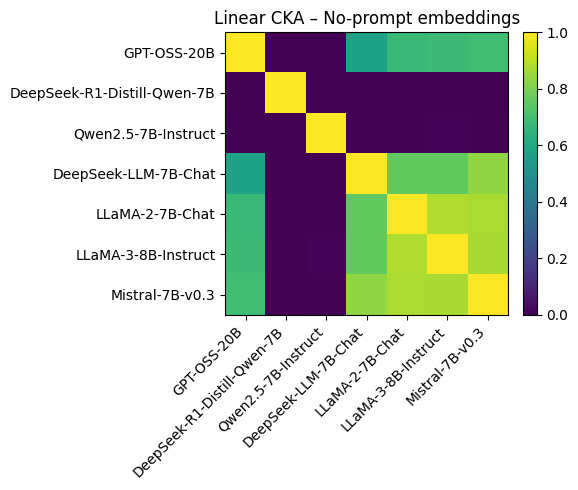

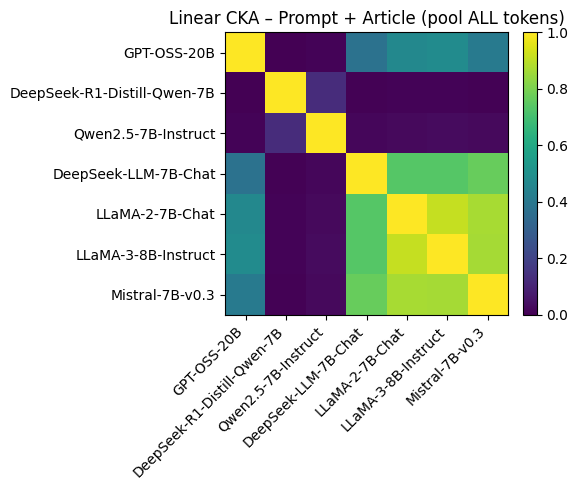

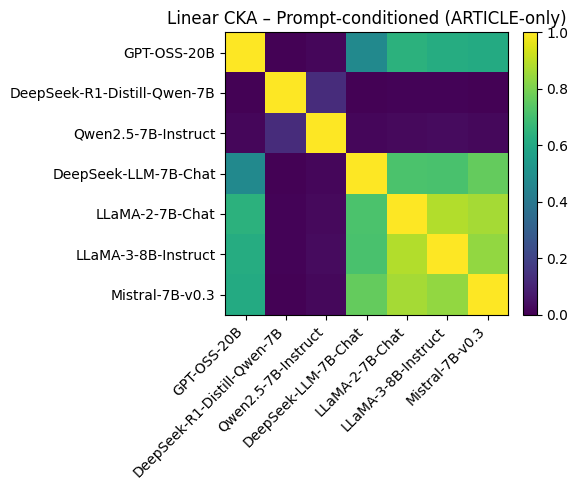

In [ ]:
for mode in MODES:
    df_lin = load_metric_df("linear_cka", mode)
    title = {
        "noprompt": "Linear CKA – No-prompt embeddings",
        "task_all": "Linear CKA – Prompt + Article (pool ALL tokens)",
        "task_article": "Linear CKA – Prompt-conditioned (ARTICLE-only)",
    }[mode]
    plot_heatmap(df_lin, title, vmin=0.0, vmax=1.0, annotate=False)
